# Code Description
This code takes the large output of a parameter estimation project and then post-processes all of the data

Functions use a standard indexing to refer to our 4 parameters: 0 index is c1, 1 is c2, 2 is T21, and 3 is T22

All parameter sets will be loaded in through the summary file associated with the result files

This code was initially written by Ryan Neff and then continued by Griffin Hampton (GSH) - Mirage Modi played a very important role in the multiprocessing of the data

# Import Packages

In [1]:
#%matplotlib widget
import scipy
import scipy.io
from scipy.optimize import curve_fit
from scipy.optimize import least_squares
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import statistics
import math
import time
import itertools
import colorsys
from tqdm import trange
from datetime import date
import pickle
import pandas as pd

# Options

In [2]:
#Initial Trial Data is Stored on 17Jan23

data_folder = "SNR_100_BIC_filter_30May23"
analysis_file = "Post_Normalized_08Jun23"

# Signal Functions

In [3]:
def G_biX_off(t, con_1, con_2, tau_1, tau_2, offSet): 
    signal = con_1*np.exp(-t/tau_1) + con_2*np.exp(-t/tau_2) + offSet
    return signal

def G_moX_off(t, con, tau, offSet): 
    signal = con*np.exp(-t/tau) + offSet
    return signal

def G_MB(t, alpha, beta, tau_1, tau_2, offSet):
    function = alpha*(beta*np.exp(-t/tau_1) + (1-beta)*np.exp(-t/tau_2)) + offSet
    return function

# Define Parameters

In [4]:
### Loading All Data Hyperparameters

with open(f'Intermediate_ExpResults/{data_folder}/{analysis_file}.pkl', 'rb') as handle:
    dict = pickle.load(handle)
    series_tag = dict['HyperParams_exp']
    gs_series_tag = dict['HyperParams_gs']
    n_iter_input = dict['iter_subset']
    post_normalize_data = dict['post_normalized']
    gs_BIC_choices = dict['gs_BIC_region']
    gs_nonreg_estimates = dict['gs_nonreg_est']
    gs_data = dict['gs_data']
    exp_BIC_region = dict['exp_BIC_region']
    nonreg_estimates = dict['exp_nonreg_est']
    GCV_estimates = dict['exp_GCV_est']
    GCV_curves = dict['exp_GCV_curves']
    GCV_lambdas = dict['exp_GCV_lam']
    all_data = dict['exp_data']
    n_hori = dict['n_horizontal']
    n_vert = dict['n_verticle']
    masked_region = dict['masked_region']
    SNR_goal = dict['SNR_goal']
    SNR_array = dict['SNR_array']
    lambdas = dict['lambdas']
    tdata = dict['tdata']
    model_oi = dict['model']
    gs_SNR_array = dict['gs_SNR'] 
    handle.close()


n_iter_input_check, n_vert_check, n_hori_check, n_parameters = nonreg_estimates.shape
assert(n_iter_input_check == n_iter_input)
assert(n_vert_check == n_vert)
assert(n_hori_check == n_hori)

c1_ref = gs_nonreg_estimates[:,:,0]

n_elements = len(tdata)

n_lambdas = len(lambdas)

###################### Parameters Loop Through

param_name_list = [r'$c_1$',r'$c_2$',r'$T_{21}$',r'$T_{22}$']

##################### Important for Naming
date = date.today()
day = date.strftime('%d')
month = date.strftime('%B')[0:3]
year = date.strftime('%y')

In [5]:
print(gs_SNR_array)

[137.50823343413293]


# Define General Functions

### Small Helper Functions

In [6]:
def construct_paramList(c1_list, T21_list, T22_list):
    preList = [item for item in itertools.product(c1_list, T21_list, T22_list)]
    postList = [list(elem) for elem in preList]
    [elem.insert(1,1-elem[0]) for elem in postList]
    return postList

def J(t, con1, con2, tau1, tau2):
    func1 = np.exp(-t/tau1)
    func2 = np.exp(-t/tau2)
    func3 = (con1*t)*np.exp(-t/tau1)/(tau1**2)
    func4 = (con2*t)*np.exp(-t/tau2)/(tau2**2)
    jacobian = np.stack((func1, func2, func3, func4), axis=-1)
    
    return jacobian

def calc_improvement(old, new):
    return (old - new)/old

def calc_improvement_ref(old, new, ref):
    return (old - new)/ref**2

def calc_improvement_diff(old, new):
    return (old - new)

#Mean Square Difference
def calculate_MSD(real, est):
    assert(real.shape == est.shape)
    square_diff = (real - est)**2
    square_diff_zero = square_diff[real!=0] #nonzero locations = we only care about the MSD around these points
    NLLS_brain_bias = np.sum(square_diff)/square_diff[square_diff>0].size #This is a better way to find 
    mean_square_diff = np.mean(square_diff_zero)
    # assert(math.isclose(NLLS_brain_bias,mean_square_diff)) #This breaks - the difference is about 5-10%
    return NLLS_brain_bias

#Mean Square Difference
def calculate_MSD_norm(real, est):
    assert(real.shape == est.shape)
    good_index = (real[:,:,0]!=0) * (est[:,:,0]!=0)
    
    square_diff = (real - est)**2
    real_divider = real.copy()
    real_divider[~good_index] = 1 #To ensure we don't divide by 0
    norm_sqD = square_diff/real_divider**2 #Divides all square differences by the square felucital value for that pixel
    sum_normSqD = np.sum(norm_sqD,axis=2) #Sum up all normalized values across the number of parameters

    MSD_metric = sum_normSqD**(1/2) #Square root value
    avg_metric = np.sum(MSD_metric)/MSD_metric[good_index].size #Average of the MSD metrics calculated

    return MSD_metric, avg_metric

def get_brain_outline(raw):
    n_vert = raw.shape[0]
    n_hori = raw.shape[1]
    I_outline = np.zeros((n_vert, n_hori))
    for i_vert in range(n_vert):
        for i_hori in range(n_hori):
            try:
                init_sig = raw[i_vert, i_hori, 0]
                if i_vert > 0:
                    init_sig_up = raw[i_vert-1, i_hori, 0]
                else:
                    init_sig_up = 0
                if i_vert < n_vert - 1:
                    init_sig_dn = raw[i_vert+1, i_hori, 0]
                else:
                    init_sig_dn = 0
                if i_hori > 0:
                    init_sig_lt = raw[i_vert, i_hori - 1, 0]
                else:
                    init_sig_lt = 0
                if i_hori < n_hori - 1:
                    init_sig_rt = raw[i_vert, i_hori + 1, 0]
                else:
                    init_sig_up = 0
                surround = [init_sig_up, init_sig_dn, init_sig_lt, init_sig_rt]
                if np.sum(surround) >0 and init_sig == 0:
                    I_outline[i_vert,i_hori] = 1
            except:
                I_outline[i_vert,i_hori] = np.nan
    return I_outline

def cov_matrix(con1, con2, tau1, tau2, SNR):
    noise_sd = 1/SNR
    jacobians = J(tdata, con1, con2, tau1, tau2).transpose()@J(tdata, con1, con2, tau1, tau2) 
    covariance = np.linalg.inv(jacobians)
    return (noise_sd**2)*covariance

def _get_colors(num_colors):
    colors = []
    for i in np.arange(0., 360., 360. / num_colors):
        hue = i/360.
        lightness = (50 + np.random.rand() *10)/100.
        saturation = (90 + np.random.rand() * 10)/100.
        colors.append(colorsys.hls_to_rgb(hue, lightness, saturation))
    return colors

# Images

### Brain Outline

Text(0.5, 1.0, 'Brain Outline')

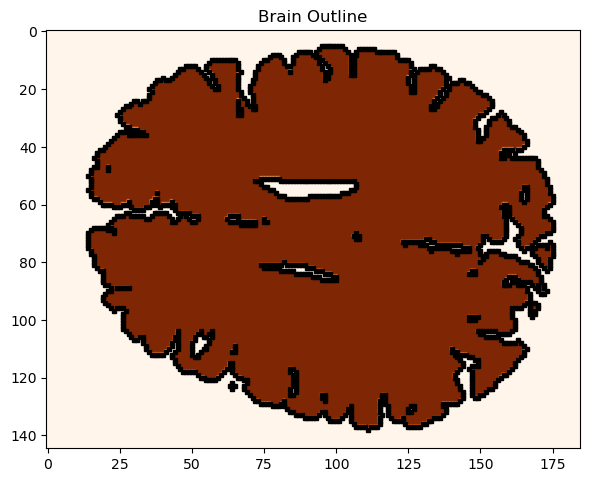

In [7]:
###########Brain Outline#################
#Use line 9 as a final line on any figure where you want to show the outline of the brain

brain_outline = get_brain_outline(masked_region)
outline_indices = np.where(brain_outline == 1)

fig, ax = plt.subplots(1,1,figsize=(6,6),tight_layout=True)
ax.imshow(masked_region[:,:,0], cmap = 'Oranges')
ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax.set_title('Brain Outline')


### BIC Regions

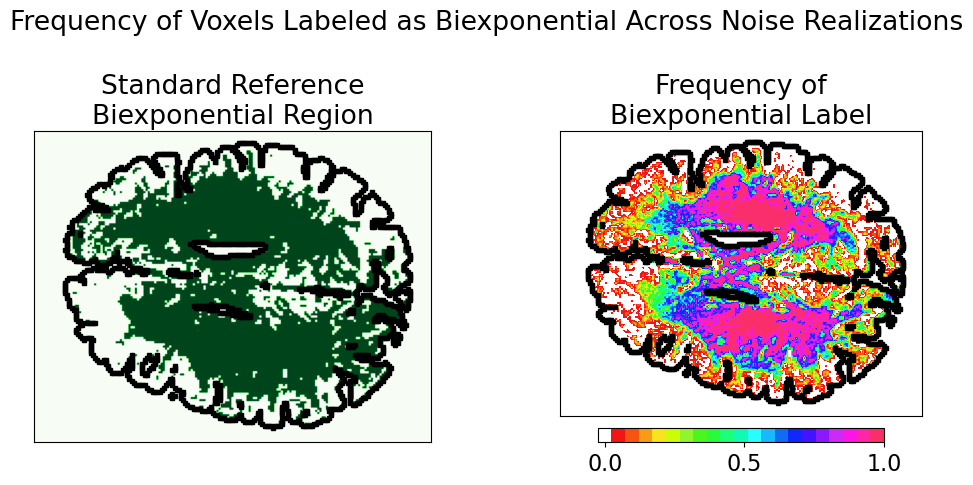

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,5),tight_layout=True)

fig.suptitle('Frequency of Voxels Labeled as Biexponential Across Noise Realizations')

ax[0].imshow(gs_BIC_choices, cmap = 'Greens')
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[0].set_title('Standard Reference\nBiexponential Region')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

gen_colors = [(1,1,1)] + _get_colors(n_iter_input)
BiX_freq_cmap = colors.ListedColormap(gen_colors)
BIC = ax[1].imshow(np.sum(exp_BIC_region, axis = 0)/exp_BIC_region.shape[0], cmap = BiX_freq_cmap, vmin = -0.5/exp_BIC_region.shape[0], vmax = (n_iter_input+0.5)//exp_BIC_region.shape[0])
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[1].set_title('Frequency of\nBiexponential Label')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
fig.colorbar(BIC, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')

Text(0.5, 1.0, 'Monoexponential')

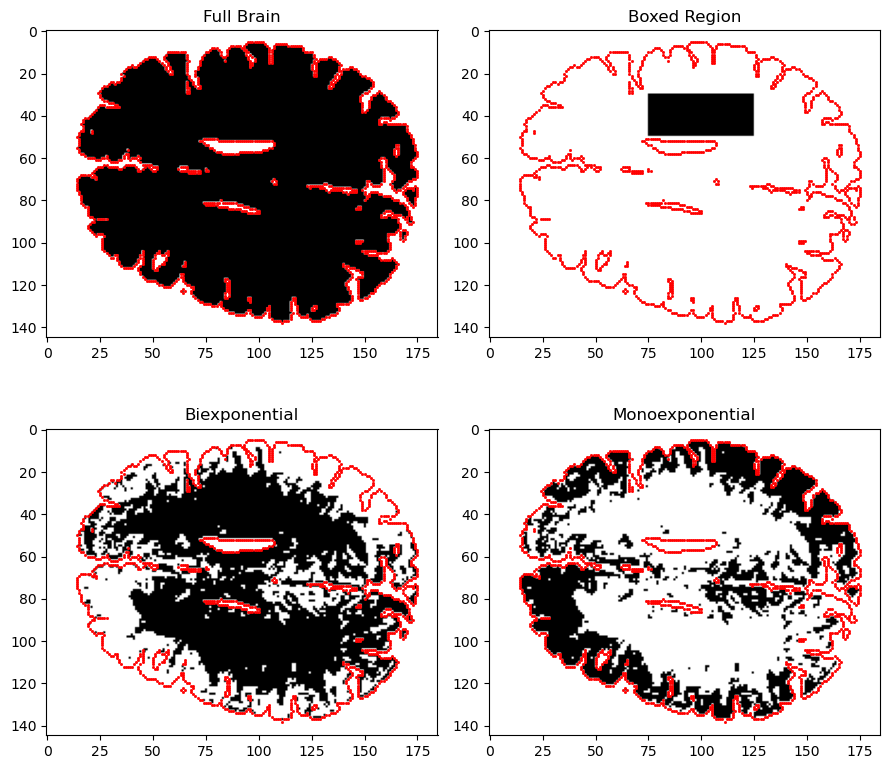

In [9]:
boxed_region = np.zeros(gs_nonreg_estimates[:,:,0].shape)
boxed_region[30:50,75:125] = 1

fig, ax = plt.subplots(2,2,figsize=(9,9),tight_layout=True)
ax[0,0].imshow(masked_region[:,:,0], cmap = 'binary', vmin=0, vmax = 1)
ax[0,0].plot(outline_indices[1],outline_indices[0], color = 'r', marker = 's', ls = '', markersize = 1)
ax[0,0].set_title('Full Brain')
ax[0,1].imshow(boxed_region, cmap = 'binary', vmin=0, vmax = 1)
ax[0,1].plot(outline_indices[1],outline_indices[0], color = 'r', marker = 's', ls = '', markersize = 1)
ax[0,1].set_title('Boxed Region')
ax[1,0].imshow(gs_BIC_choices, cmap = 'binary', vmin=0, vmax = 1)
ax[1,0].plot(outline_indices[1],outline_indices[0], color = 'r', marker = 's', ls = '', markersize = 1)
ax[1,0].set_title('Biexponential')
ax[1,1].imshow(masked_region[:,:,0] - gs_BIC_choices, cmap = 'binary', vmin=0, vmax = 1)
ax[1,1].plot(outline_indices[1],outline_indices[0], color = 'r', marker = 's', ls = '', markersize = 1)
ax[1,1].set_title('Monoexponential')

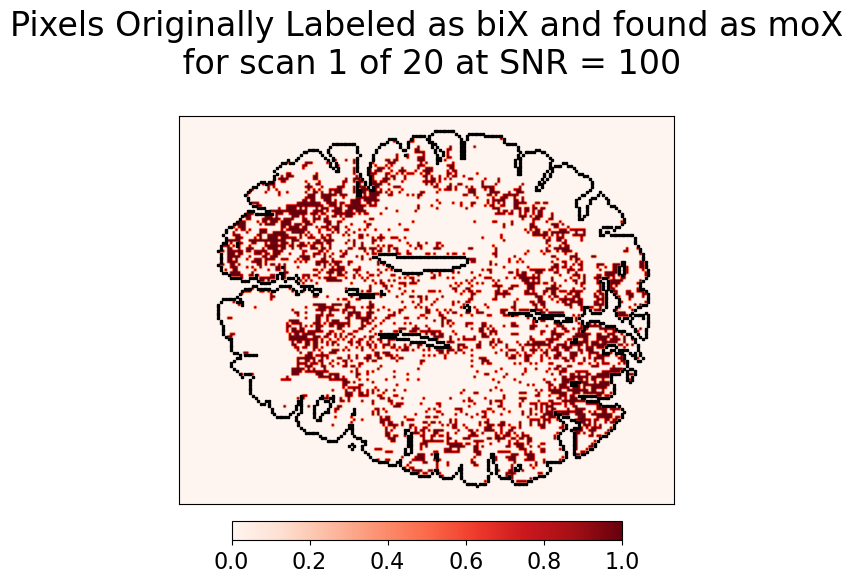

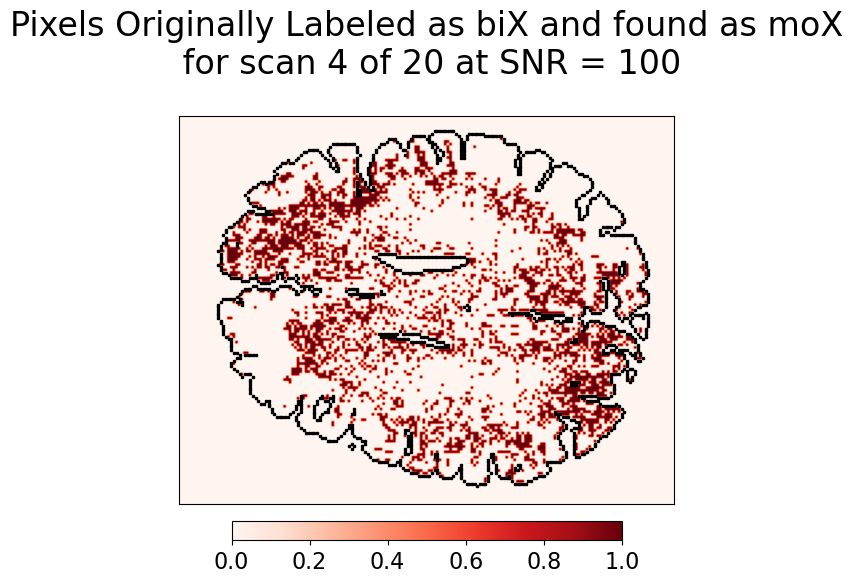

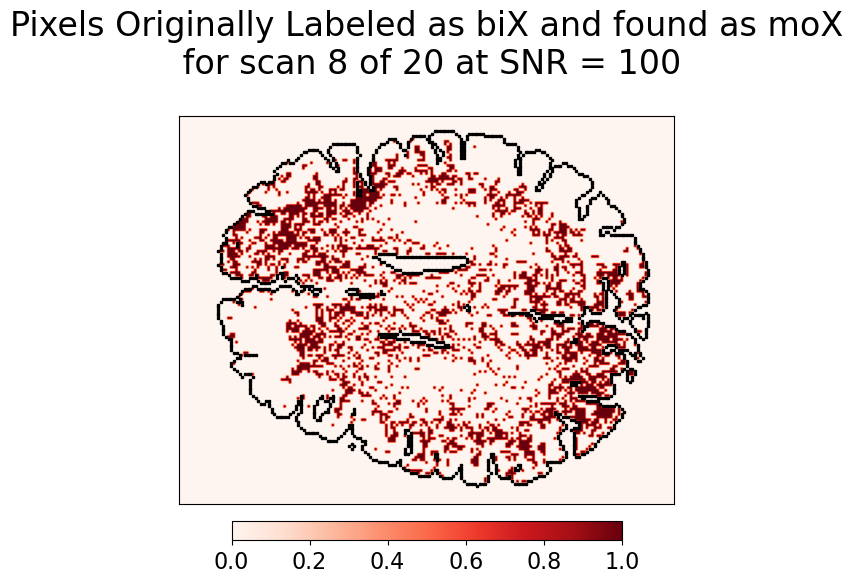

In [10]:
### Pixels Originally Labeled as biX that were found as moX

scan_num_list = [0,3,7]#np.arange(0,n_iter_input,1)

for scan_num in scan_num_list:
    
    fig, ax = plt.subplots(1,1,figsize=(9,6),tight_layout=True)
    plt.rc('font', size  = 20)
    fig.suptitle(f'Pixels Originally Labeled as biX and found as moX\n for scan {scan_num+1} of {n_iter_input} at SNR = {SNR_goal}' )
    plt.rc('font', size  = 16)


    pNLLS = ax.imshow(gs_BIC_choices * (exp_BIC_region[scan_num,:,:]+1)%2, cmap = 'Reds')
    cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
    # ax[0].set_title('')
    ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)


    # plt.rc('font', size  = 13)
    # fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
    # fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')

    plt.show()

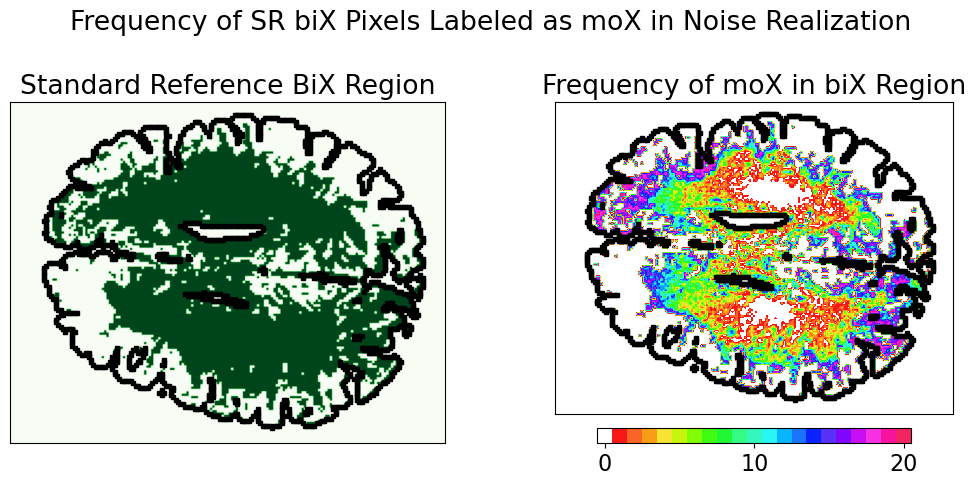

In [11]:
pix_biX_og_moX_analysis = gs_BIC_choices * (exp_BIC_region+1)%2

fig, ax = plt.subplots(1,2, figsize=(12,5),tight_layout=True)

fig.suptitle('Frequency of SR biX Pixels Labeled as moX in Noise Realization')

ax[0].imshow(gs_BIC_choices, cmap = 'Greens')
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[0].set_title('Standard Reference BiX Region')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

gen_colors = [(1,1,1)] + _get_colors(n_iter_input)
BiX_freq_cmap = colors.ListedColormap(gen_colors)
BIC = ax[1].imshow(np.sum(pix_biX_og_moX_analysis, axis = 0), cmap = BiX_freq_cmap, vmin = -0.5, vmax = n_iter_input+0.5)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[1].set_title('Frequency of moX in biX Region')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
fig.colorbar(BIC, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')

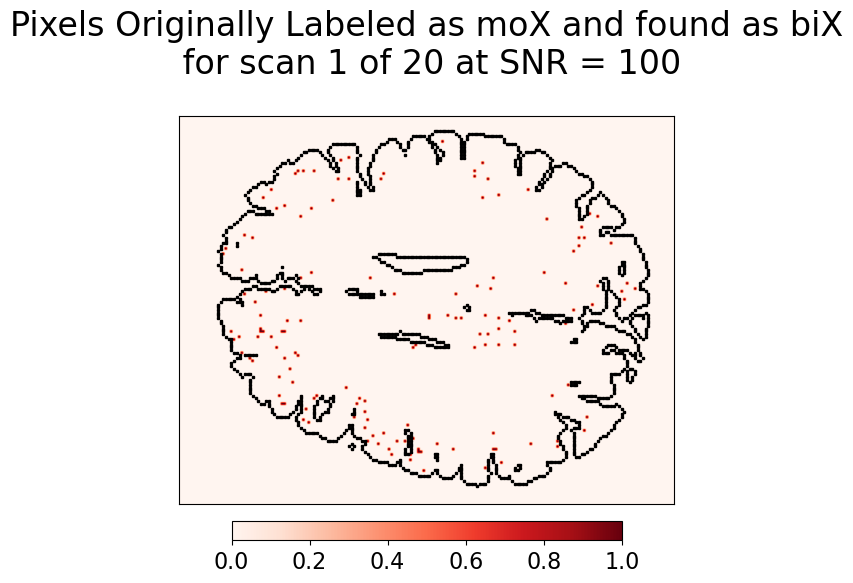

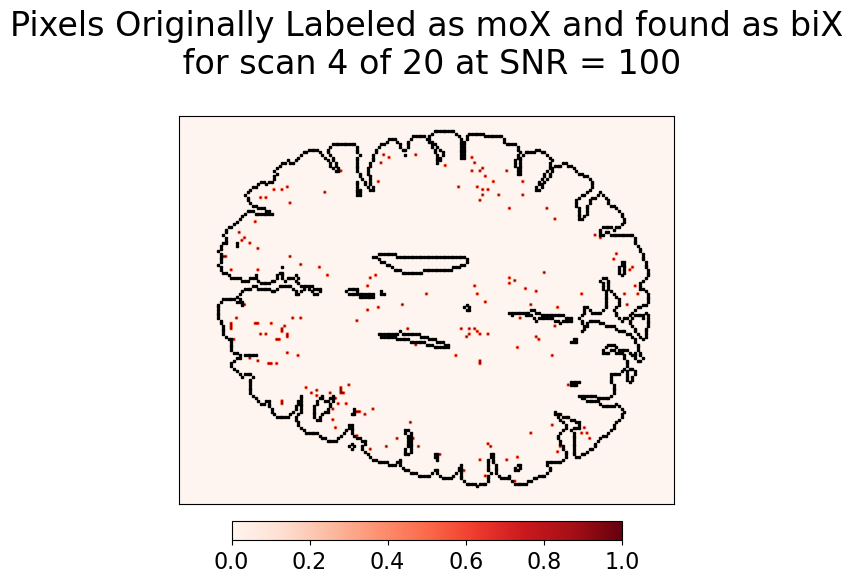

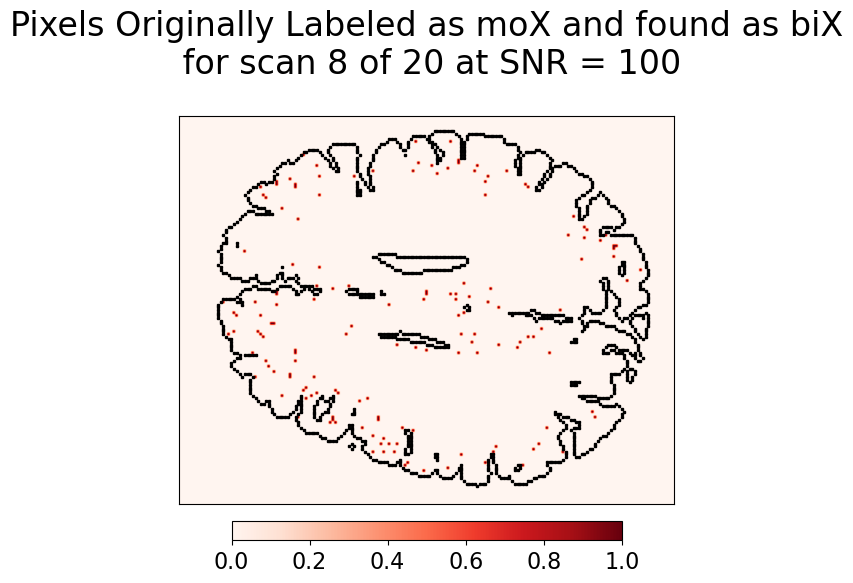

In [12]:
### Pixels Originally Labeled as biX that were found as moX

scan_num_list = [0,3,7]#np.arange(0,n_iter_input,1)

for scan_num in scan_num_list:
    
    fig, ax = plt.subplots(1,1,figsize=(9,6),tight_layout=True)
    plt.rc('font', size  = 20)
    fig.suptitle(f'Pixels Originally Labeled as moX and found as biX\n for scan {scan_num+1} of {n_iter_input} at SNR = {SNR_goal}' )
    plt.rc('font', size  = 16)


    pNLLS = ax.imshow((gs_BIC_choices+1)%2 * exp_BIC_region[scan_num,:,:], cmap = 'Reds')
    cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
    # ax[0].set_title('')
    ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)


    # plt.rc('font', size  = 13)
    # fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
    # fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')

    plt.show()

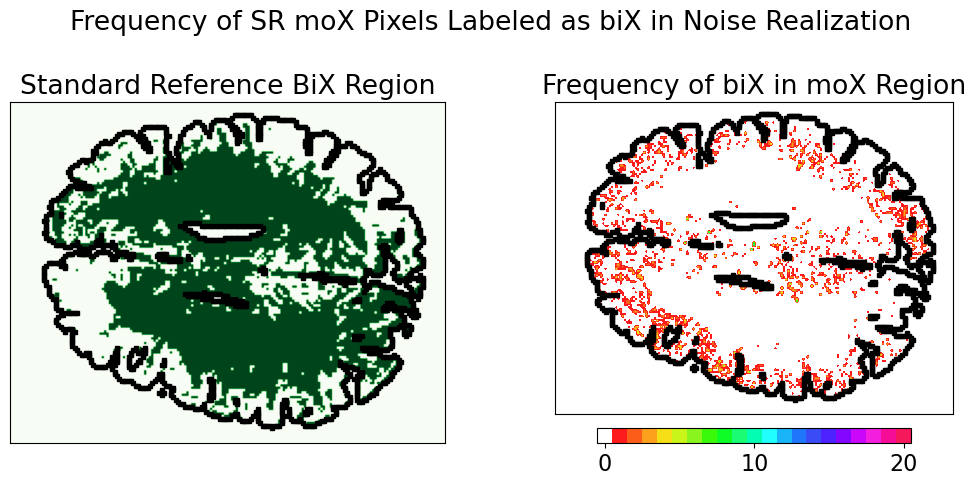

In [13]:
pix_moX_og_biX_analysis = (gs_BIC_choices+1)%2 * exp_BIC_region

fig, ax = plt.subplots(1,2, figsize=(12,5),tight_layout=True)

fig.suptitle('Frequency of SR moX Pixels Labeled as biX in Noise Realization')

ax[0].imshow(gs_BIC_choices, cmap = 'Greens')
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[0].set_title('Standard Reference BiX Region')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

gen_colors = [(1,1,1)] + _get_colors(n_iter_input)
BiX_freq_cmap = colors.ListedColormap(gen_colors)
BIC = ax[1].imshow(np.sum(pix_moX_og_biX_analysis, axis = 0), cmap = BiX_freq_cmap, vmin = -0.5, vmax = n_iter_input+0.5)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 2.5)
ax[1].set_title('Frequency of biX in moX Region')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
fig.colorbar(BIC, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')

##### Parameter Maps

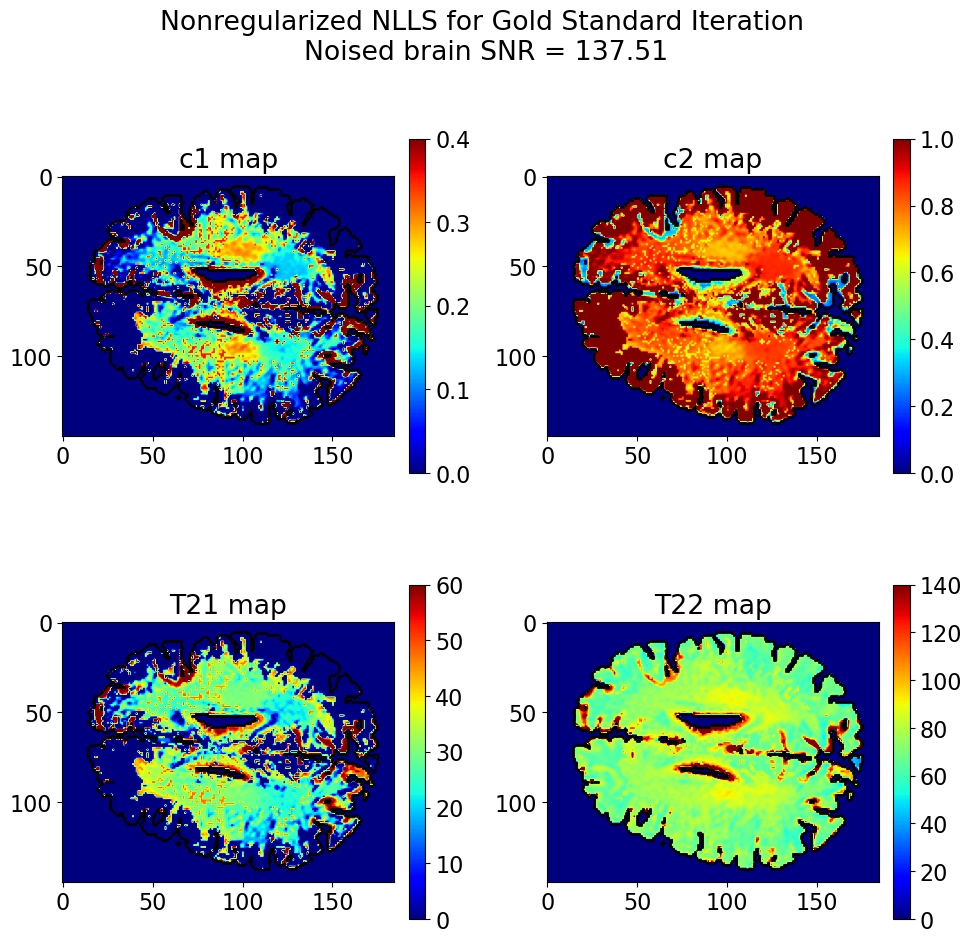

In [14]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle(f'Nonregularized NLLS for Gold Standard Iteration \nNoised brain SNR = {np.round(gs_SNR_array[0],2)}' )

imc1 = ax[0,0].imshow(gs_nonreg_estimates[:,:,0], cmap = 'jet', vmin=0, vmax = 0.4)
ax[0,0].set_title('c1 map')
ax[0,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc2 = ax[0,1].imshow(gs_nonreg_estimates[:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('c2 map')
ax[0,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)

imT21 = ax[1,0].imshow(gs_nonreg_estimates[:,:,2], cmap = 'jet', vmin=0, vmax = 60)
ax[1,0].set_title('T21 map')
ax[1,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT22 = ax[1,1].imshow(gs_nonreg_estimates[:,:,3], cmap = 'jet', vmin=0, vmax = 140)
ax[1,1].set_title('T22 map')
ax[1,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)

fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

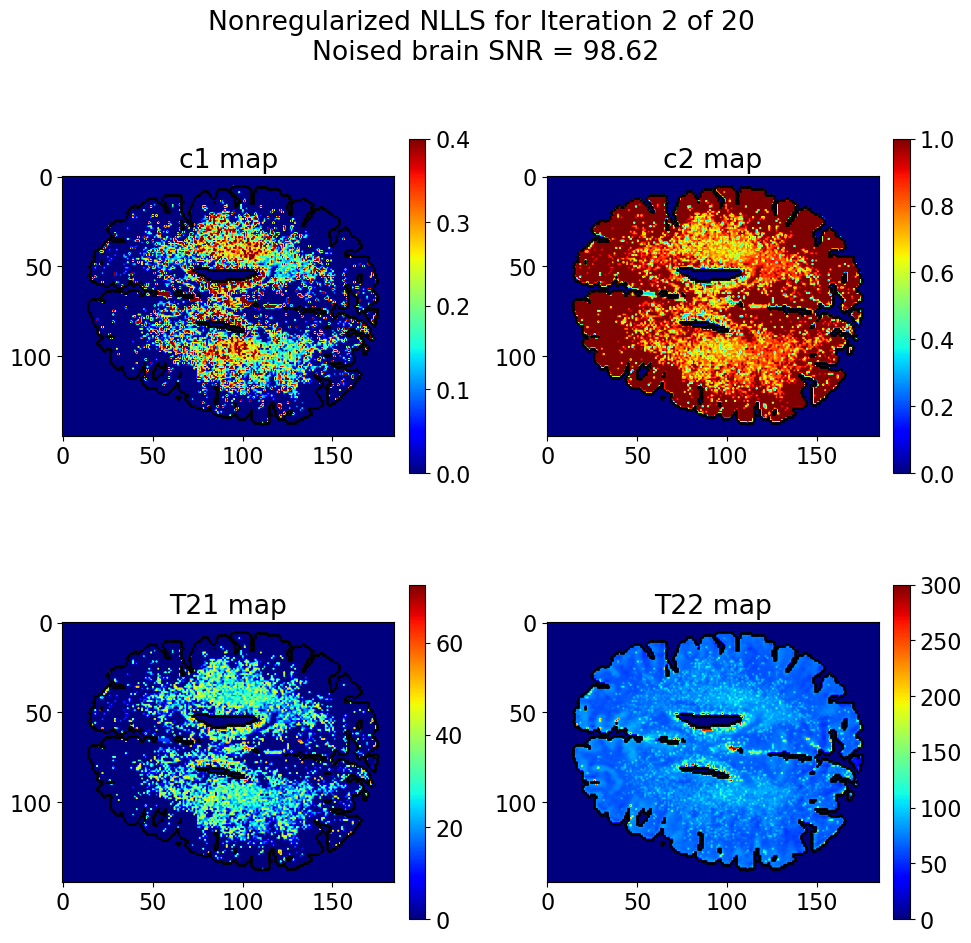

In [15]:
iter_oi = 1
assert(iter_oi < n_iter_input)

fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle(f'Nonregularized NLLS for Iteration {iter_oi+1} of {n_iter_input} \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )
imc1 = ax[0,0].imshow(nonreg_estimates[iter_oi,:,:,0], cmap = 'jet', vmin=0, vmax=0.4)
ax[0,0].set_title('c1 map')
ax[0,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc2 = ax[0,1].imshow(nonreg_estimates[iter_oi,:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('c2 map')
ax[0,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT21 = ax[1,0].imshow(nonreg_estimates[iter_oi,:,:,2], cmap = 'jet', vmin=0)
ax[1,0].set_title('T21 map')
ax[1,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT22 = ax[1,1].imshow(nonreg_estimates[iter_oi,:,:,3], cmap = 'jet', vmin=0)
ax[1,1].set_title('T22 map')
ax[1,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

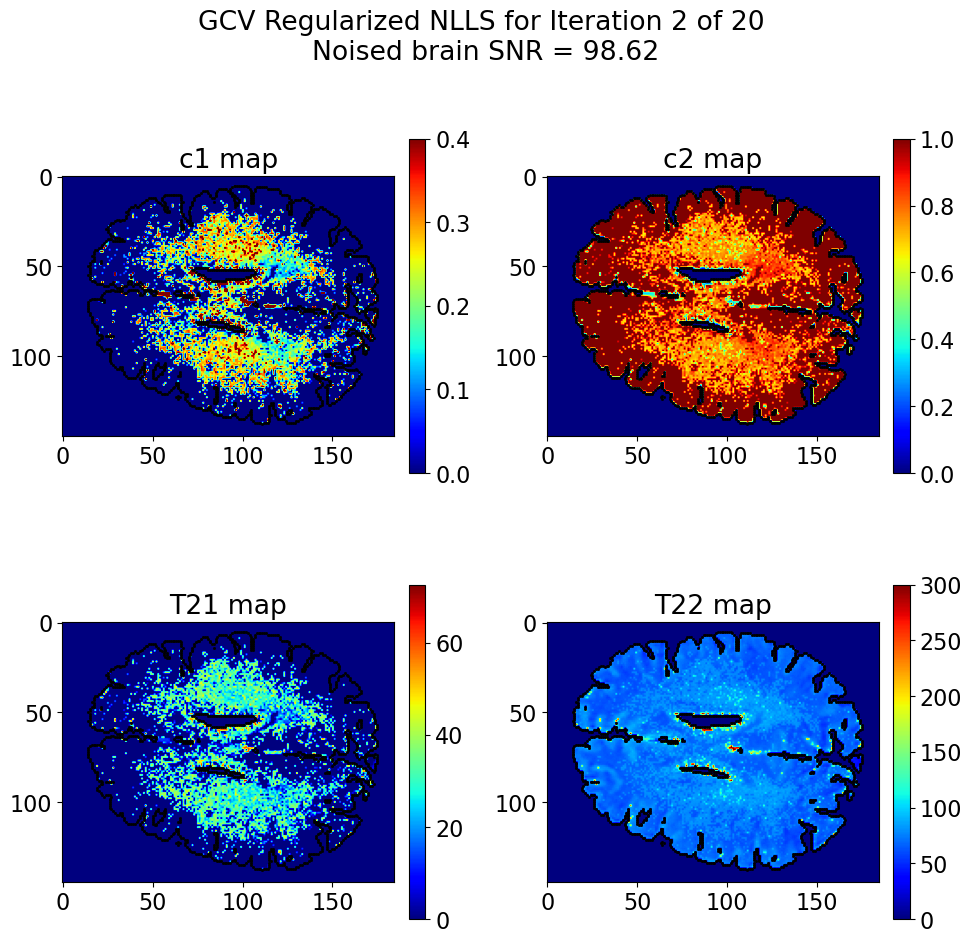

In [16]:
fig, ax = plt.subplots(2,2,figsize=(10,10),tight_layout=True)
fig.suptitle(f'GCV Regularized NLLS for Iteration {iter_oi+1} of {n_iter_input} \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )
imc1 = ax[0,0].imshow(GCV_estimates[iter_oi,:,:,0], cmap = 'jet', vmin=0, vmax=0.4)
ax[0,0].set_title('c1 map')
ax[0,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc2 = ax[0,1].imshow(GCV_estimates[iter_oi,:,:,1], cmap = 'jet', vmin=0, vmax=1)
ax[0,1].set_title('c2 map')
ax[0,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT21 = ax[1,0].imshow(GCV_estimates[iter_oi,:,:,2], cmap = 'jet', vmin=0)
ax[1,0].set_title('T21 map')
ax[1,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imT22 = ax[1,1].imshow(GCV_estimates[iter_oi,:,:,3], cmap = 'jet', vmin=0)
ax[1,1].set_title('T22 map')
ax[1,1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

fig.colorbar(imc1, ax=ax[0,0], fraction=0.046, pad=0.04)
fig.colorbar(imc2, ax=ax[0,1], fraction=0.046, pad=0.04)
fig.colorbar(imT21, ax=ax[1,0], fraction=0.046, pad=0.04)
fig.colorbar(imT22, ax=ax[1,1], fraction=0.046, pad=0.04)
plt.show()

##### Regularization Curve Analysis

/tmp/ipykernel_255956/155759047.py:10: RuntimeWarning: divide by zero encountered in log10
  imc2 = ax[1].imshow(np.log10(GCV_lambdas[iter_oi,:,:]), cmap = 'jet')


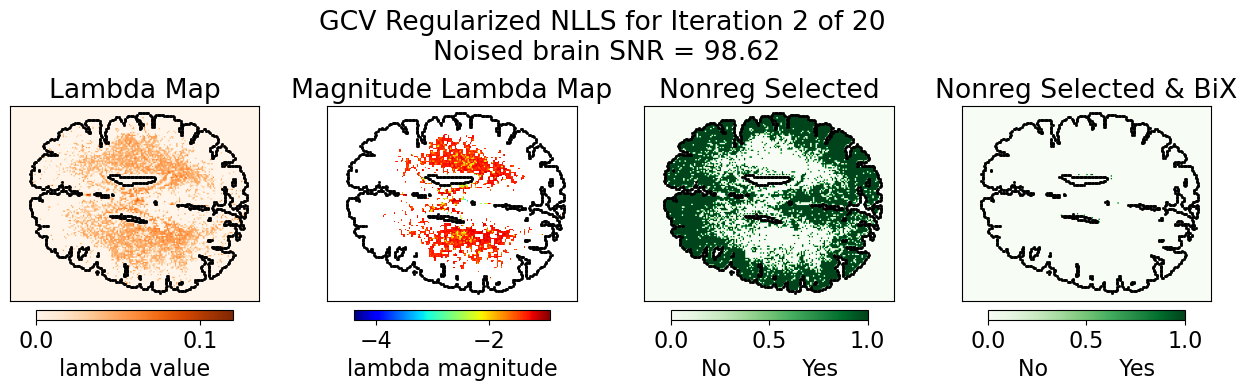

In [17]:
fig, ax = plt.subplots(1, 4, figsize=(13,4), tight_layout=True)
fig.suptitle(f'GCV Regularized NLLS for Iteration {iter_oi+1} of {n_iter_input} \nNoised brain SNR = {np.round(SNR_array[iter_oi],2)}' )

imc1 = ax[0].imshow(GCV_lambdas[iter_oi,:,:], cmap = 'Oranges')
ax[0].set_title('Lambda Map')
fig.colorbar(imc1, ax=ax[0], fraction=0.046, pad=0.04, label = 'lambda value', location = 'bottom')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc2 = ax[1].imshow(np.log10(GCV_lambdas[iter_oi,:,:]), cmap = 'jet')
ax[1].set_title('Magnitude Lambda Map')
fig.colorbar(imc2, ax=ax[1], fraction=0.046, pad=0.04, label = 'lambda magnitude', location = 'bottom')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc3 = ax[2].imshow((GCV_lambdas[iter_oi,:,:]==0)*masked_region[:,:,0], cmap = 'Greens')
ax[2].set_title('Nonreg Selected')
fig.colorbar(imc3, ax=ax[2], fraction=0.046, pad=0.04, label = 'No          Yes', location = 'bottom')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

imc4 = ax[3].imshow((GCV_lambdas[iter_oi,:,:]==0)*masked_region[:,:,0]*exp_BIC_region[iter_oi,:,:], cmap = 'Greens')
ax[3].set_title('Nonreg Selected & BiX')
fig.colorbar(imc4, ax=ax[3], fraction=0.046, pad=0.04, label = 'No          Yes', location = 'bottom')
ax[3].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[3].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

plt.show()

##### MWF Comparison Graphs

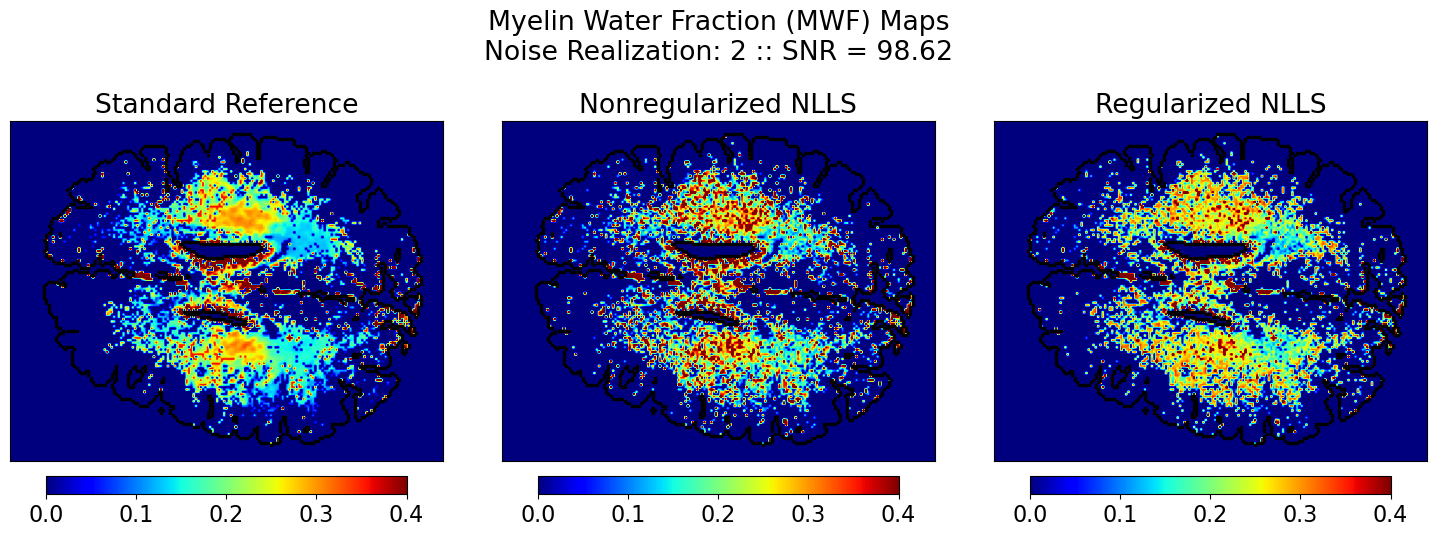

In [25]:
fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
plt.rc('font', size  = 16)
fig.suptitle('Myelin Water Fraction (MWF) Maps' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
imref = ax[0].imshow(c1_ref*exp_BIC_region[iter_oi,:,:], cmap = 'jet', vmin = 0, vmax = 0.4)
ax[0].set_title('Standard Reference')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

imNLLS = ax[1].imshow(nonreg_estimates[iter_oi,:,:,0]*exp_BIC_region[iter_oi,:,:], cmap = 'jet', vmin=0, vmax=0.4)
ax[1].set_title('Nonregularized NLLS')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

imGCV = ax[2].imshow(GCV_estimates[iter_oi,:,:,0]*exp_BIC_region[iter_oi,:,:], cmap = 'jet', vmin=0, vmax=0.4)
ax[2].set_title('Regularized NLLS')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

fig.colorbar(imref,ax=ax[0],fraction=0.046, pad=0.04, location = "bottom")
fig.colorbar(imNLLS,ax=ax[1],fraction=0.046, pad=0.04, location = "bottom")
fig.colorbar(imGCV,ax=ax[2],fraction=0.046, pad=0.04, location = "bottom")
plt.show()

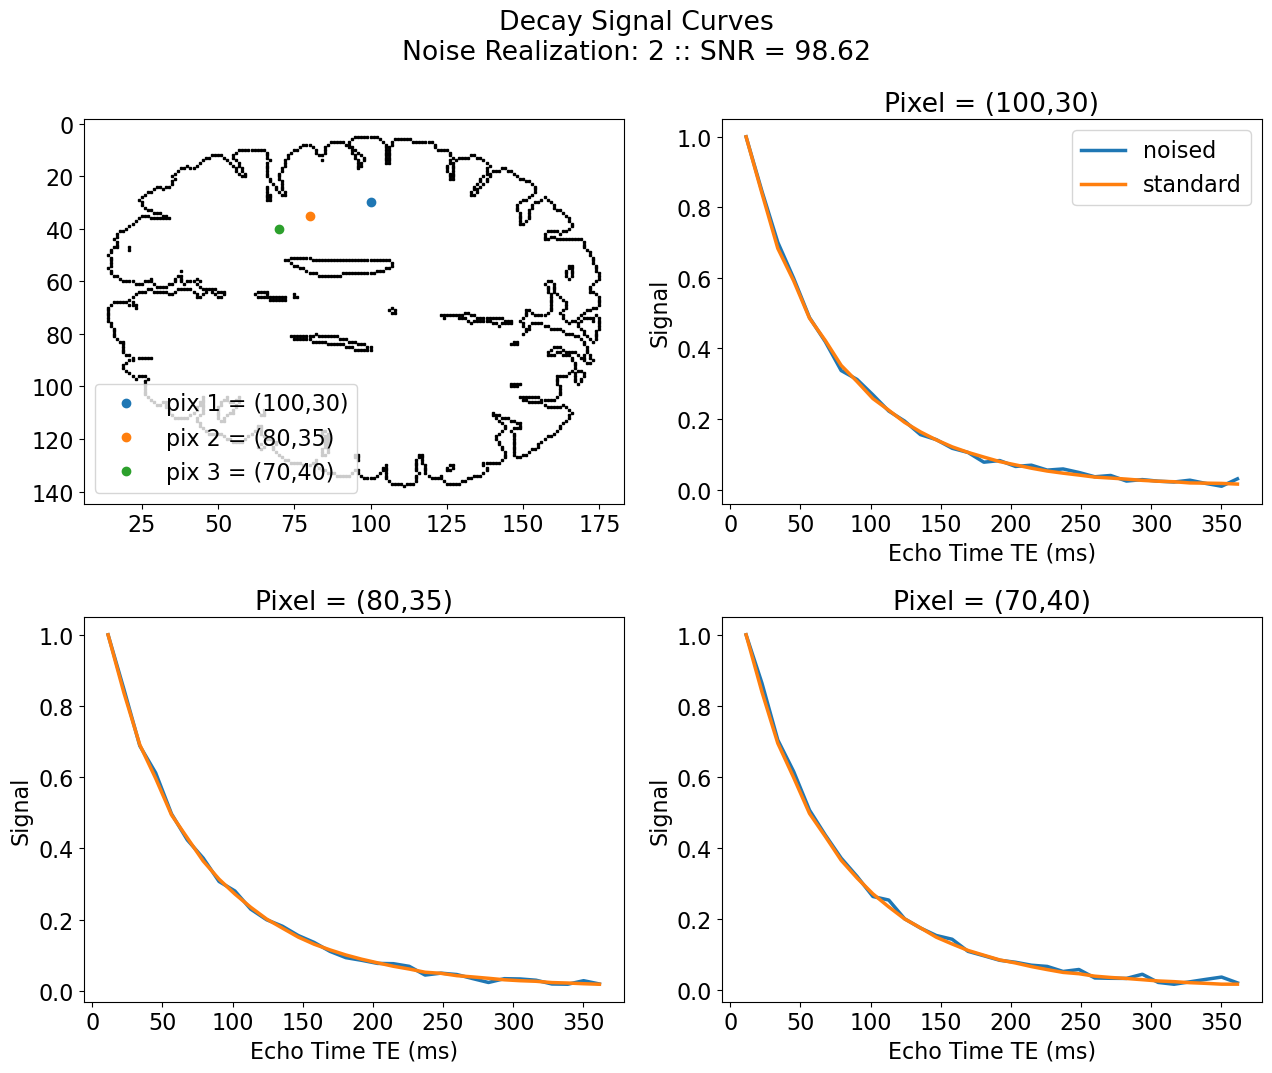

In [ ]:
x_oi_1 = 100
y_oi_1 = 30

x_oi_2 = 80
y_oi_2 = 35

x_oi_3 = 70
y_oi_3 = 40


fig, ax = plt.subplots(2,2,figsize=(13,11),tight_layout=True)
plt.rc('font', size  = 16)
fig.suptitle('Decay Signal Curves' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
ax[0,0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
ax[0,0].plot(x_oi_1,y_oi_1,label = f"pix 1 = ({x_oi_1},{y_oi_1})", marker = "o", ls = '')
ax[0,0].plot(x_oi_2,y_oi_2,label = f"pix 2 = ({x_oi_2},{y_oi_2})", marker = "o", ls = '')
ax[0,0].plot(x_oi_3,y_oi_3,label = f"pix 3 = ({x_oi_3},{y_oi_3})", marker = "o", ls = '')
ax[0,0].invert_yaxis()
ax[0,0].legend()

ax[0,1].plot(tdata, all_data[iter_oi,y_oi_1,x_oi_1,:], label = "noised", linewidth = 2.5)
ax[0,1].plot(tdata, gs_data[y_oi_1,x_oi_1,:], label = "standard", linewidth = 2.5)
ax[0,1].legend()
ax[0,1].set_xlabel('Echo Time TE (ms)')
ax[0,1].set_ylabel('Signal')
ax[0,1].set_title(f"Pixel = ({x_oi_1},{y_oi_1})")

ax[1,0].plot(tdata, all_data[iter_oi,y_oi_2,x_oi_2,:], label = "noised", linewidth = 2.5)
ax[1,0].plot(tdata, gs_data[y_oi_2,x_oi_2,:], label = "standard", linewidth = 2.5)
ax[1,0].set_xlabel('Echo Time TE (ms)')
ax[1,0].set_ylabel('Signal')
ax[1,0].set_title(f"Pixel = ({x_oi_2},{y_oi_2})")

ax[1,1].plot(tdata, all_data[iter_oi,y_oi_3,x_oi_3,:], label = "noised", linewidth = 2.5)
ax[1,1].plot(tdata, gs_data[y_oi_3,x_oi_3,:], label = "standard", linewidth = 2.5)
ax[1,1].set_xlabel('Echo Time TE (ms)')
ax[1,1].set_ylabel('Signal')
ax[1,1].set_title(f"Pixel = ({x_oi_3},{y_oi_3})")

plt.show()

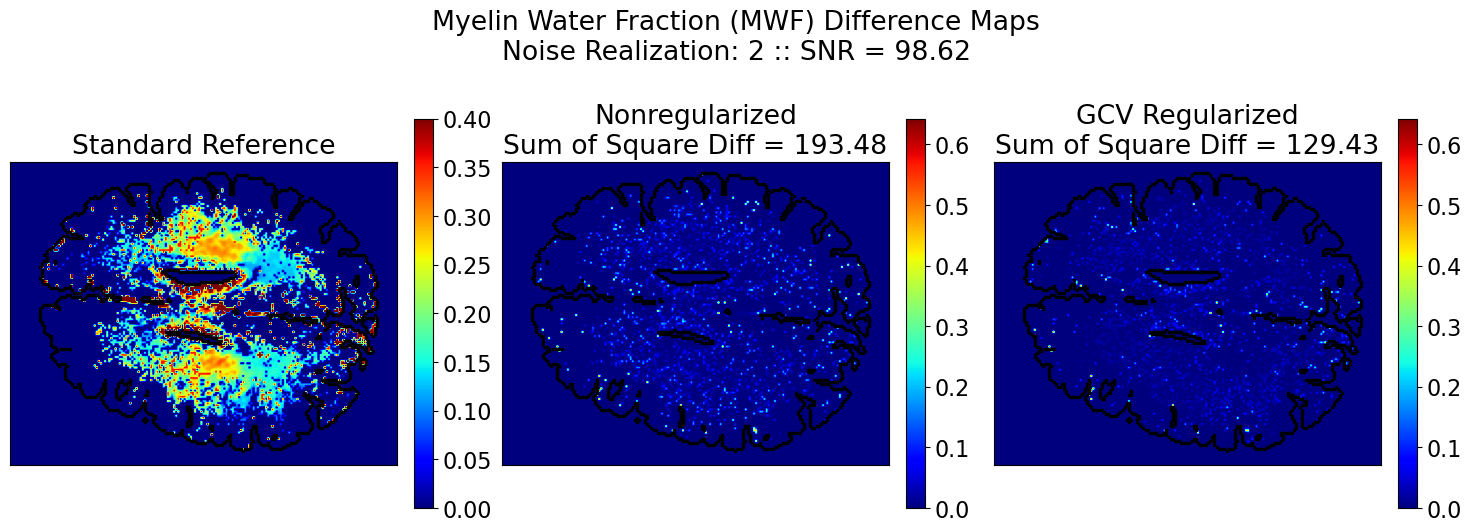

In [ ]:
NLLS_diff = (nonreg_estimates[iter_oi,:,:,0] - c1_ref)**2
GCV_diff = (GCV_estimates[iter_oi,:,:,0] - c1_ref)**2

NLLS_MSD = calculate_MSD(c1_ref, nonreg_estimates[iter_oi,:,:,0])
GCV_MSD = calculate_MSD(c1_ref, GCV_estimates[iter_oi,:,:,0])

NLLS_MSD_map, NLLS_MSD_norm = calculate_MSD_norm(gs_nonreg_estimates, nonreg_estimates[iter_oi,:,:,:])
GCV_MSD_map, GCV_MSD_norm = calculate_MSD_norm(gs_nonreg_estimates, GCV_estimates[iter_oi,:,:,:])

NR_metric = np.sum(NLLS_diff[np.where(exp_BIC_region[iter_oi,:,:])])
GCV_metric = np.sum(GCV_diff[np.where(exp_BIC_region[iter_oi,:,:])])

fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
plt.rc('font', size  = 16)
fig.suptitle('Myelin Water Fraction (MWF) Difference Maps' + '\nNoise Realization: '+ str(iter_oi+1) + ' :: SNR = ' + str(np.round(SNR_array[iter_oi],2)))
imref = ax[0].imshow(c1_ref*exp_BIC_region[iter_oi,:,:], cmap = 'jet', vmin = 0, vmax = 0.4)
ax[0].set_title('Standard Reference')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

imNLLS = ax[1].imshow(NLLS_diff*exp_BIC_region[iter_oi,:,:], cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
ax[1].set_title(f'Nonregularized\nSum of Square Diff = {NR_metric:0.2f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
# ax[1].text(10, 10, 'Mean square difference = %s'%round(NLLS_MSD,5), color='w')
# ax[1].text(10, 20, 'All Param Mean Square Difference = %s'%round(NLLS_MSD_total,5), color='w')
# ax[1].text(10, 20, 'All Norm Mean Square Difference = %s'%round(NLLS_MSD_norm,5), color='w')

imGCV = ax[2].imshow(GCV_diff*exp_BIC_region[iter_oi,:,:], cmap = 'jet', vmin=0, vmax=np.max([NLLS_diff,GCV_diff]))
ax[2].set_title(f'GCV Regularized\nSum of Square Diff = {GCV_metric:0.2f}')
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
# ax[2].text(10, 10, 'Mean square difference = %s'%round(GCV_MSD,5), color='w')
# ax[2].text(10, 20, 'All Param Mean Square Difference = %s'%round(GCV_MSD_total,5), color='w')
# ax[2].text(10, 20, 'All Norm Mean Square Difference = %s'%round(GCV_MSD_norm,5), color='w')

fig.colorbar(imref,ax=ax[0],fraction=0.046, pad=0.04)
fig.colorbar(imNLLS,ax=ax[1],fraction=0.046, pad=0.04)
fig.colorbar(imGCV,ax=ax[2],fraction=0.046, pad=0.04)
plt.show()

##### MSE Composistion Maps

In [ ]:
params_oi = [0]        #We are primarily interested in c1 which makes the 0th parameter the interesting one

varMap_NLLS = np.var(nonreg_estimates, axis = 0)
varMap_GCV = np.var(GCV_estimates, axis = 0)

sqbMap_NLLS = (np.mean(nonreg_estimates, axis = 0) - gs_nonreg_estimates)**2
sqbMap_GCV = (np.mean(GCV_estimates, axis = 0) - gs_nonreg_estimates)**2

MSEMap_NLLS = varMap_NLLS + sqbMap_NLLS
MSEMap_GCV = varMap_GCV + sqbMap_GCV

/tmp/ipykernel_170446/3328933816.py:17: RuntimeWarning: invalid value encountered in divide
  return (old - new)/old


Post Normalized: True


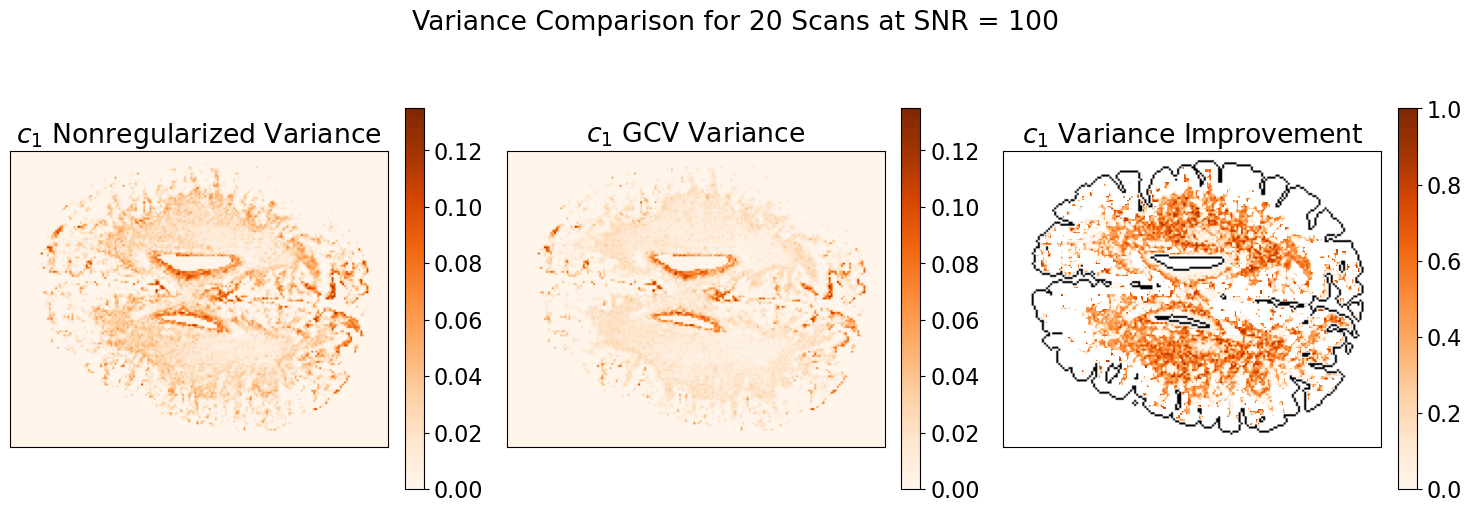

In [ ]:
#Variance Improvment Under Regularization Cases

var_improvement = calc_improvement(varMap_NLLS, varMap_GCV)
sqBias_improvement = calc_improvement(sqbMap_NLLS, sqbMap_GCV)
MSE_improvement = calc_improvement(MSEMap_NLLS, MSEMap_GCV)

or_map = plt.get_cmap('Oranges')
# or_map.set_extremes(under = 'blue')
extend_opt = "neither" #min, max, both, neither

print(f'Post Normalized: {post_normalize_data}')
for param_oi in params_oi:

    fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
    plt.rc('font', size  = 16)
    fig.suptitle(f'Variance Comparison for {n_iter_input} Scans at SNR = {SNR_goal}' )

    ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[0].imshow(varMap_NLLS[:,:,param_oi], cmap = or_map, vmin=0)
    cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[0].set_title(param_name_list[param_oi] + ' Nonregularized Variance' )
    ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[1].imshow(varMap_GCV[:,:,param_oi], cmap = or_map, vmin=0)
    fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[1].set_title(param_name_list[param_oi] + ' GCV Variance' )
    ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    ax[2].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
    pNLLS = ax[2].imshow(var_improvement[:,:,param_oi], cmap = or_map, vmin=0, vmax=1)
    fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04, extend = extend_opt)
    ax[2].set_title(param_name_list[param_oi] + ' Variance Improvement' )
    ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

    plt.show()

/tmp/ipykernel_170446/3328933816.py:17: RuntimeWarning: invalid value encountered in divide
  return (old - new)/old


Post Normalized: True


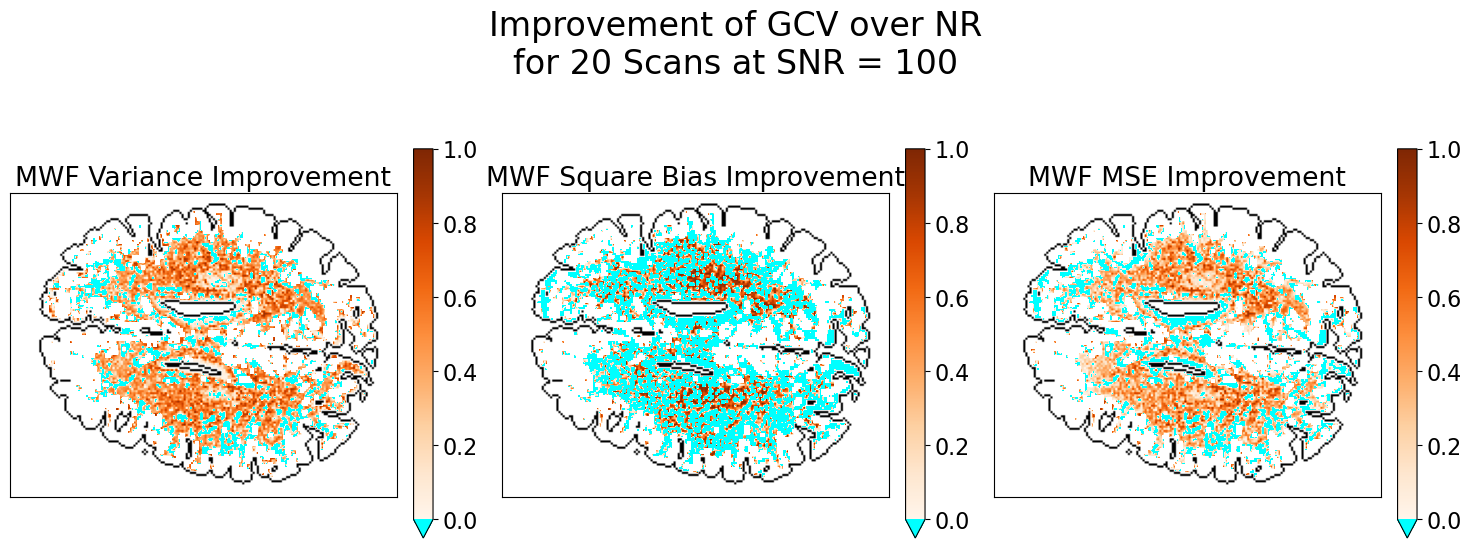

In [ ]:
#MSE Component Improvement Figures

var_improvement = calc_improvement(varMap_NLLS, varMap_GCV)
sqBias_improvement = calc_improvement(sqbMap_NLLS, sqbMap_GCV)
MSE_improvement = calc_improvement(MSEMap_NLLS, MSEMap_GCV)

or_map = plt.get_cmap('Oranges')
or_map.set_extremes(under = 'cyan')
extend_opt = "min"


print(f'Post Normalized: {post_normalize_data}')

fig, ax = plt.subplots(1,3,figsize=(15,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Improvement of GCV over NR\nfor {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)
ax[0].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[0].imshow(var_improvement[:,:,0], cmap = or_map, vmin=0, vmax=1)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, extend = extend_opt)
ax[0].set_title('MWF Variance Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(var_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

ax[1].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[1].imshow(sqBias_improvement[:,:,0], cmap = or_map, vmin=0, vmax=1)
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04, extend = extend_opt)
ax[1].set_title('MWF Square Bias Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(sqBias_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

ax[2].imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax[2].imshow(MSE_improvement[:,:,0], cmap = or_map, vmin=0, vmax=1)
fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04, extend = extend_opt)
ax[2].set_title('MWF MSE Improvement')# + '\nAverage Improvement= ' + str(round(np.mean(MSE_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)

plt.show()

Post Normalized: True


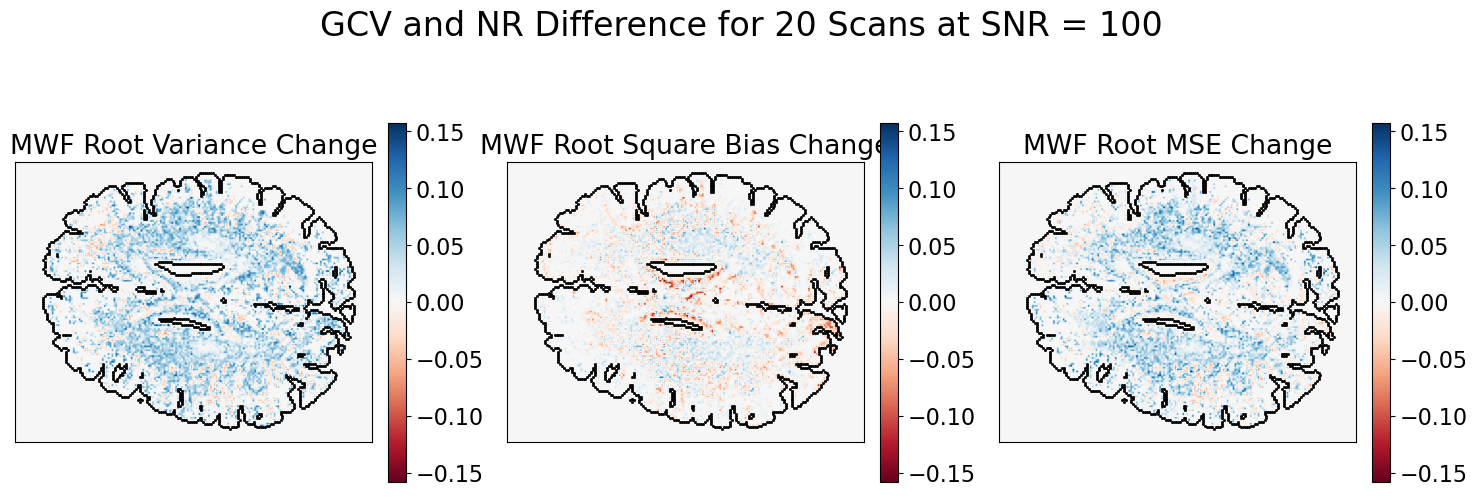

In [ ]:
print(f'Post Normalized: {post_normalize_data}')

or_map = plt.get_cmap('RdBu')

var_diff = varMap_NLLS -  varMap_GCV
sqBias_diff = sqbMap_NLLS - sqbMap_GCV
MSE_diff = MSEMap_NLLS - MSEMap_GCV

Rvar_diff = varMap_NLLS**(1/2) -  varMap_GCV**(1/2)
RsqBias_diff = sqbMap_NLLS**(1/2) - sqbMap_GCV**(1/2)
RMSE_diff = MSEMap_NLLS**(1/2) - MSEMap_GCV**(1/2)

RMSERange = np.max(np.abs(RMSE_diff[:,:,0]))


# MSERange = 0.05
        
fig, ax = plt.subplots(1,3,figsize=(15,5.5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'GCV and NR Difference for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(Rvar_diff[:,:,0], cmap = or_map, vmin=-RMSERange, vmax = RMSERange)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04)
ax[0].set_title('MWF Root Variance Change' )#+ '\nAverage Improvement= ' + str(round(np.mean(var_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

pNLLS = ax[1].imshow(RsqBias_diff[:,:,0], cmap = or_map, vmin=-RMSERange, vmax = RMSERange)
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.04)
ax[1].set_title('MWF Root Square Bias Change' )#+ '\nAverage Improvement= ' + str(round(np.mean(sqBias_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

pNLLS = ax[2].imshow(RMSE_diff[:,:,0], cmap = or_map, vmin=-RMSERange, vmax = RMSERange)
fig.colorbar(pNLLS,ax=ax[2], fraction=0.046, pad=0.04)
ax[2].set_title('MWF Root MSE Change' )#+ '\nAverage Improvement= ' + str(round(np.mean(MSE_improvement[:,:,param_oi][c1_ref!=0]),2)))
ax[2].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[2].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1)

plt.show()

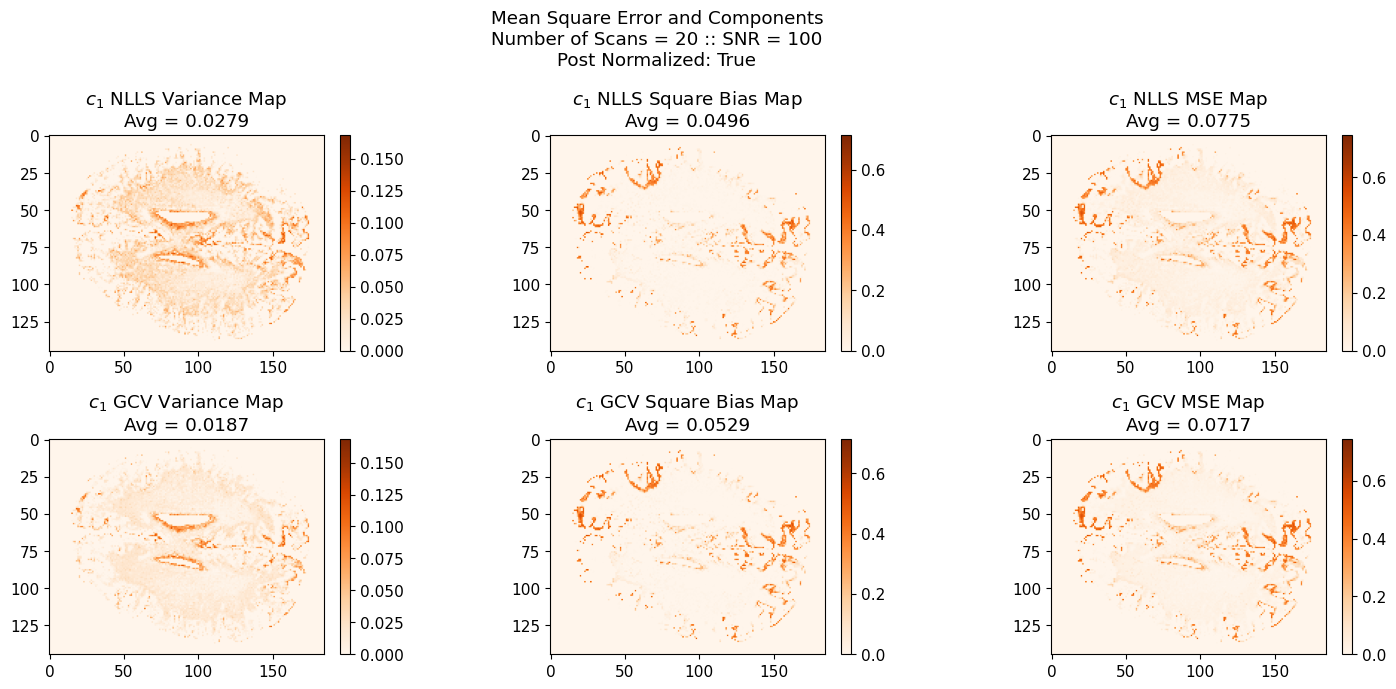

In [ ]:
### MSE Component Maps - Comparison against nonreg and GCV
for param_oi in params_oi:

    plt.rc('font', size  = 11)
    fig, ax = plt.subplots(2,3,figsize=(15,7),tight_layout=True)
    fig.suptitle('Mean Square Error and Components' + f'\nNumber of Scans = {n_iter_input} :: SNR = {SNR_goal}\nPost Normalized: {post_normalize_data}' )

    pNLLS = ax[0,0].imshow(varMap_NLLS[:,:,param_oi], cmap = 'Oranges', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,param_oi],varMap_GCV[:,:,param_oi]]))
    fig.colorbar(pNLLS,ax=ax[0,0], fraction=0.046, pad=0.04)
    ax[0,0].set_title(param_name_list[param_oi] + ' NLLS Variance Map' + '\nAvg = ' + str(round(np.mean(varMap_NLLS[:,:,param_oi][c1_ref!=0]),4)))

    pGCV = ax[1,0].imshow(varMap_GCV[:,:,param_oi], cmap = 'Oranges', vmin=0, vmax=1.25*np.max([varMap_NLLS[:,:,param_oi],varMap_GCV[:,:,param_oi]]))
    fig.colorbar(pGCV,ax=ax[1,0], fraction=0.046, pad=0.04)
    ax[1,0].set_title(param_name_list[param_oi] + ' GCV Variance Map' + '\nAvg = ' + str(round(np.mean(varMap_GCV[:,:,param_oi][c1_ref!=0]),4)))

    pNLLS = ax[0,1].imshow(sqbMap_NLLS[:,:,param_oi], cmap = 'Oranges', vmin=0, vmax=1.25*np.max([sqbMap_NLLS[:,:,param_oi],sqbMap_GCV[:,:,param_oi]]))
    fig.colorbar(pNLLS,ax=ax[0,1], fraction=0.046, pad=0.04)
    ax[0,1].set_title(param_name_list[param_oi] + ' NLLS Square Bias Map' + '\nAvg = ' + str(round(np.mean(sqbMap_NLLS[:,:,param_oi][c1_ref!=0]),4)))

    pGCV = ax[1,1].imshow(sqbMap_GCV[:,:,param_oi], cmap = 'Oranges', vmin=0, vmax=1.25*np.max([sqbMap_NLLS[:,:,param_oi],sqbMap_GCV[:,:,param_oi]]))
    fig.colorbar(pGCV,ax=ax[1,1], fraction=0.046, pad=0.04)
    ax[1,1].set_title(param_name_list[param_oi] + ' GCV Square Bias Map' + '\nAvg = ' + str(round(np.mean(sqbMap_GCV[:,:,param_oi][c1_ref!=0]),4)))

    pNLLS = ax[0,2].imshow(MSEMap_NLLS[:,:,param_oi], cmap = 'Oranges', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,param_oi],MSEMap_GCV[:,:,param_oi]]))
    fig.colorbar(pNLLS,ax=ax[0,2], fraction=0.046, pad=0.04)
    ax[0,2].set_title(param_name_list[param_oi] + ' NLLS MSE Map' + '\nAvg = ' + str(round(np.mean(MSEMap_NLLS[:,:,param_oi][c1_ref!=0]),4)))

    pGCV = ax[1,2].imshow(MSEMap_GCV[:,:,param_oi], cmap = 'Oranges', vmin=0, vmax=1.25*np.max([MSEMap_NLLS[:,:,param_oi],MSEMap_GCV[:,:,param_oi]]))
    fig.colorbar(pGCV,ax=ax[1,2], fraction=0.046, pad=0.04)
    ax[1,2].set_title(param_name_list[param_oi] + ' GCV MSE Map' + '\nAvg = ' + str(round(np.mean(MSEMap_GCV[:,:,param_oi][c1_ref!=0]),4)))

    plt.show()

##### MSE MWF Maps

-0.07897490684386245
0.15761310605559808


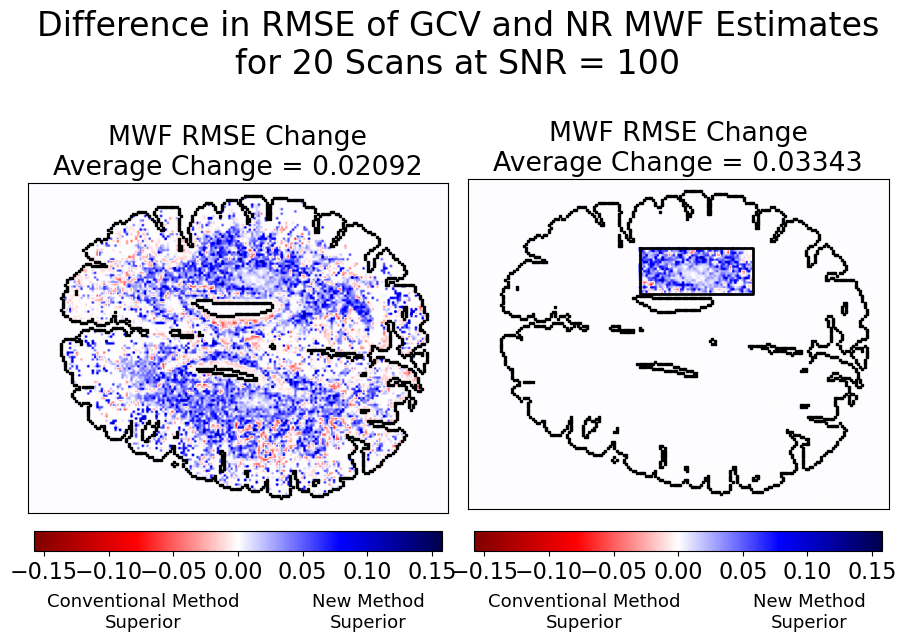

In [ ]:
### MSE = Var + Bias**2 Calculation

MSE_fullBrain = RMSE_diff[:,:,0]*masked_region[:,:,0]
MSE_box = RMSE_diff[:,:,0]*boxed_region

MSE_fullBrain_nonZ = MSE_fullBrain[np.where(np.sum(exp_BIC_region, axis = 0) > 0)]
MSE_box_nonZ = MSE_box[np.where(boxed_region)]


print(np.min(RMSE_diff[:,:,0]))
print(np.max(RMSE_diff[:,:,0]))

fig, ax = plt.subplots(1,2,figsize=(9,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Difference in RMSE of GCV and NR MWF Estimates\nfor {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(MSE_fullBrain, cmap = 'seismic_r', vmin=-RMSERange, vmax = RMSERange)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title('MWF RMSE Change' + f'\nAverage Change = {np.mean(MSE_fullBrain_nonZ):0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(MSE_box, cmap = 'seismic_r', vmin=-RMSERange, vmax = RMSERange)
ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
ax[1].set_title('MWF RMSE Change' + f'\nAverage Change = {np.mean(MSE_box_nonZ):0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
# fig.colorbar(t22_im_error, ax = t22_error_plot, location = "bottom",  pad = 0.05)


plt.rc('font', size  = 13)
fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.64, -0.05,"Conventional Method\nSuperior", ha='center')

plt.show()

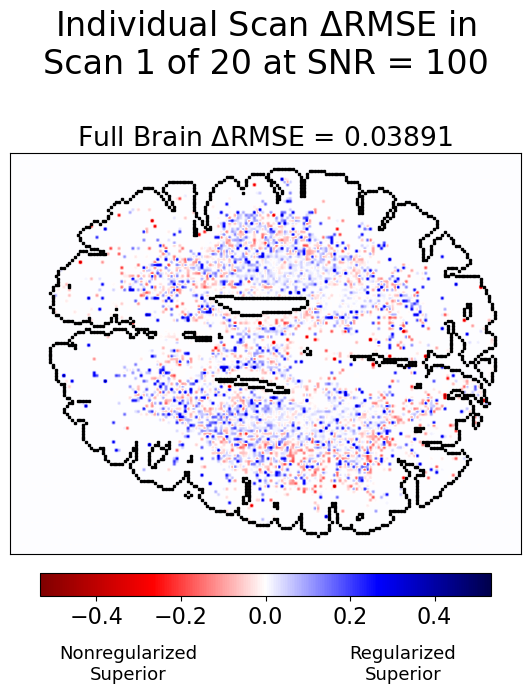

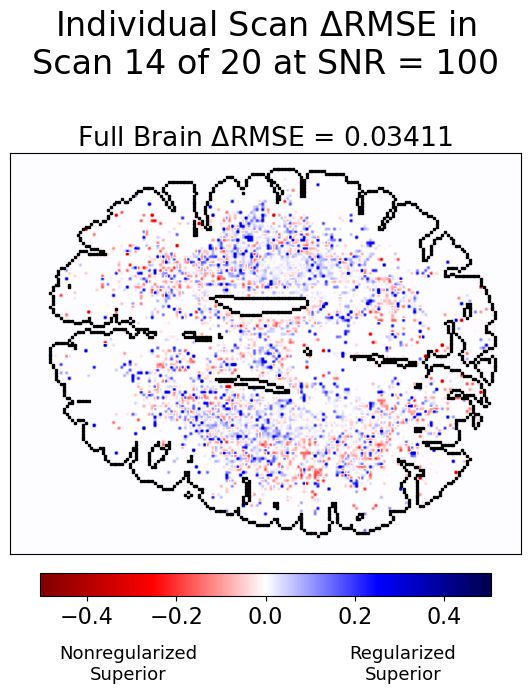

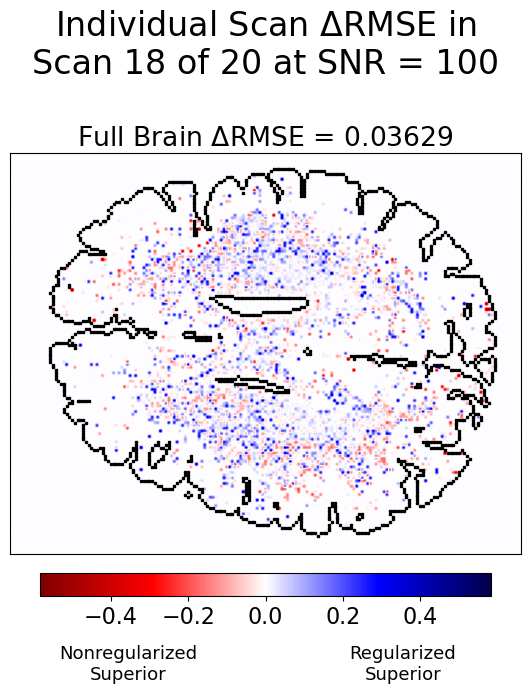

In [ ]:
### Individual Plot Calculations

scan_num_list = [0,13,17]#np.arange(0,n_iter_input,1)

list_NR_DRMSE = []

for scan_num in scan_num_list:

    new_diff = np.abs(GCV_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])
    old_diff = np.abs(nonreg_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*exp_BIC_region[scan_num,:,:]

    num_vox = np.sum(exp_BIC_region[scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum((nonreg_estimates[scan_num,:,:,0]*exp_BIC_region[scan_num,:,:] - gs_nonreg_estimates[:,:,0]*exp_BIC_region[scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum((GCV_estimates[scan_num,:,:,0]*exp_BIC_region[scan_num,:,:] - gs_nonreg_estimates[:,:,0]*exp_BIC_region[scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new
    
    fig, ax = plt.subplots(1,1,figsize=(5.5,6.5),tight_layout=True)
    plt.rc('font', size  = 20)
    delta_txt = r'$\Delta$'
    fig.suptitle(f'Individual Scan {delta_txt}RMSE in\nScan {scan_num+1} of {n_iter_input} at SNR = {SNR_goal}' )
    plt.rc('font', size  = 16)

    pNLLS = ax.imshow(ACD_fullBrain, cmap = 'seismic_r', vmin=-ACDRange, vmax = ACDRange)
    cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
    ax.set_title(f'Full Brain {delta_txt}RMSE = {indiv_brain_meas:0.5f}')
    ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
    ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

    plt.rc('font', size  = 13)
    fig.text(0.25, -0.05,"Nonregularized\nSuperior", ha='center')
    fig.text(0.75, -0.05,"Regularized\nSuperior", ha='center')


    plt.show()

    list_NR_DRMSE.append(indiv_brain_meas)

In [ ]:
### Averaging Metrics of individual plots

scan_num_list = np.arange(0,n_iter_input,1)

avg_change = []
root_avg_square_change = []

for scan_num in scan_num_list:

    #Generates differences for each individual pixel
    new_diff = np.abs(GCV_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])
    old_diff = np.abs(nonreg_estimates[scan_num,:,:,0] - gs_nonreg_estimates[:,:,0])

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff
    ACDRange = np.max(np.abs(absolute_comparative_diff))

    ACD_fullBrain = absolute_comparative_diff*exp_BIC_region[scan_num,:,:]

    num_vox = np.sum(exp_BIC_region[scan_num,:,:])

    indiv_brain_old = (1/num_vox*np.sum((nonreg_estimates[scan_num,:,:,0]*exp_BIC_region[scan_num,:,:] - gs_nonreg_estimates[:,:,0]*exp_BIC_region[scan_num,:,:])**2))**(1/2)
    indiv_brain_new = (1/num_vox*np.sum((GCV_estimates[scan_num,:,:,0]*exp_BIC_region[scan_num,:,:] - gs_nonreg_estimates[:,:,0]*exp_BIC_region[scan_num,:,:])**2))**(1/2)
    indiv_brain_meas = indiv_brain_old - indiv_brain_new

    root_avg_square_change.append(indiv_brain_meas)

print(f"Avg Full Brain {delta_txt}RMSE for 20 noise realizations = {np.mean(root_avg_square_change)}")
print(f"Std Full Brain {delta_txt}RMSE for 20 noise realizations = {np.std(root_avg_square_change)}")
print(f"Min Full Brain {delta_txt}RMSE for 20 noise realizations = {np.min(root_avg_square_change)}")
print(f"Max Full Brain {delta_txt}RMSE for 20 noise realizations = {np.max(root_avg_square_change)}")

Avg Full Brain $\Delta$RMSE for 20 noise realizations = 0.03512704519472105
Std Full Brain $\Delta$RMSE for 20 noise realizations = 0.002102608017321302
Min Full Brain $\Delta$RMSE for 20 noise realizations = 0.031158483545687704
Max Full Brain $\Delta$RMSE for 20 noise realizations = 0.039391389446311875


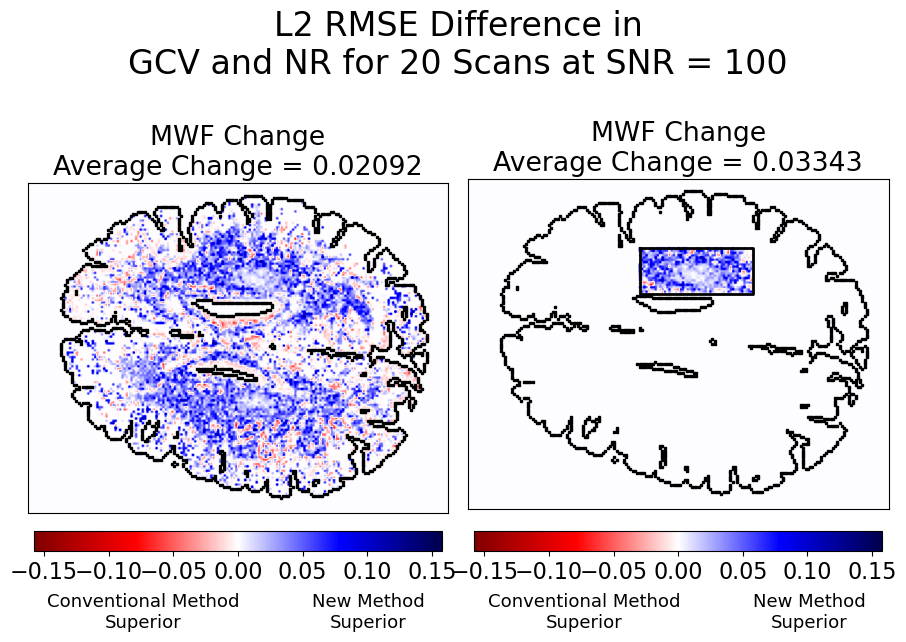

In [ ]:
### L2 MWF Change - all Noise Realizations

new_diff = (1/n_iter_input*np.sum((GCV_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)
old_diff = (1/n_iter_input*np.sum((nonreg_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)

#Abbreviated as ACD
L2_MSE_Diff = old_diff - new_diff
L2_MSE_Range = np.max(np.abs(L2_MSE_Diff))

L2_MSE_fullBrain = L2_MSE_Diff*masked_region[:,:,0]
L2_MSE_box = L2_MSE_Diff*boxed_region

L2_MSE_fullBrain_values = L2_MSE_fullBrain[np.where(np.sum(exp_BIC_region, axis = 0) > 0)]
L2_MSE_box_values = L2_MSE_box[np.where(boxed_region)]

fig, ax = plt.subplots(1,2,figsize=(9,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'L2 RMSE Difference in\nGCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(L2_MSE_fullBrain, cmap = 'seismic_r', vmin=-L2_MSE_Range, vmax = L2_MSE_Range)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title('MWF Change' + f'\nAverage Change = {np.mean(L2_MSE_fullBrain_values):0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

pNLLS = ax[1].imshow(L2_MSE_box, cmap = 'seismic_r', vmin=-L2_MSE_Range, vmax = L2_MSE_Range)
ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
ax[1].set_title('MWF Change' + f'\nAverage Change = {np.mean(L2_MSE_box_values):0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

plt.rc('font', size  = 13)
fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.64, -0.05,"Conventional Method\nSuperior", ha='center')

plt.show()

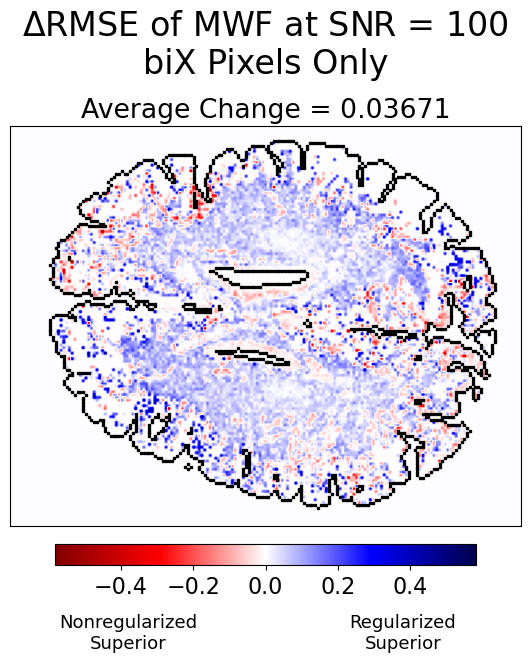

In [ ]:
### L2 MWF Change - only BIC Noise Realizations

BIC_divisor = np.sum(exp_BIC_region, axis = 0)
BIC_divisor[BIC_divisor == 0] = 1

new_diff = (1/BIC_divisor*np.sum((GCV_estimates[:,:,:,0]*exp_BIC_region - gs_nonreg_estimates[:,:,0]*exp_BIC_region)**2, axis = 0))**(1/2)
old_diff = (1/BIC_divisor*np.sum((nonreg_estimates[:,:,:,0]*exp_BIC_region - gs_nonreg_estimates[:,:,0]*exp_BIC_region)**2, axis = 0))**(1/2)

#Abbreviated as ACD
L2_MSE_Diff_BIC_count = old_diff - new_diff
L2_MSE_Range_BIC_count = np.max(np.abs(L2_MSE_Diff_BIC_count))

L2_MSE_fullBrain_BIC_count = L2_MSE_Diff_BIC_count*masked_region[:,:,0]
L2_MSE_box_BIC_count = L2_MSE_Diff_BIC_count*boxed_region

L2_MSE_fullBrain_BIC_count_values = L2_MSE_fullBrain_BIC_count[np.where(np.sum(exp_BIC_region, axis = 0) > 0)]
L2_MSE_box_BIC_count_values = L2_MSE_box_BIC_count[np.where(boxed_region)]

# fig, ax = plt.subplots(1,2,figsize=(9,6),tight_layout=True)
# plt.rc('font', size  = 20)
# fig.suptitle(f'L2 RMSE Difference in\nGCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}\nbiX Pixels Only' )
# plt.rc('font', size  = 16)

# pNLLS = ax[0].imshow(L2_MSE_fullBrain_BIC_count, cmap = 'seismic_r', vmin=-L2_MSE_Range_BIC_count, vmax = L2_MSE_Range_BIC_count)
# cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
# ax[0].set_title('MWF Change' + f'\nAverage Change = {np.mean(L2_MSE_fullBrain_BIC_count_values):0.5f}')
# ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
# ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

# pNLLS = ax[1].imshow(L2_MSE_box_BIC_count, cmap = 'seismic_r', vmin=-L2_MSE_Range_BIC_count, vmax = L2_MSE_Range_BIC_count)
# ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
# fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
# ax[1].set_title('MWF Change' + f'\nAverage Change = {np.mean(L2_MSE_box_BIC_count_values):0.5f}')
# ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
# ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

# plt.rc('font', size  = 13)
# fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
# fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
# fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
# fig.text(0.64, -0.05,"Conventional Method\nSuperior", ha='center')

# plt.show()

fig, ax = plt.subplots(1,1,figsize=(5.5,6.2),tight_layout=True)
plt.rc('font', size  = 20)
delta_txt = r'$\Delta$'
fig.suptitle(f'{delta_txt}RMSE of MWF at SNR = {SNR_goal}\nbiX Pixels Only' )
plt.rc('font', size  = 16)

pNLLS = ax.imshow(L2_MSE_fullBrain_BIC_count, cmap = 'seismic_r', vmin=-L2_MSE_Range_BIC_count, vmax = L2_MSE_Range_BIC_count)
cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
ax.set_title(f'Average Change = {np.mean(L2_MSE_fullBrain_BIC_count_values):0.5f}')
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)

plt.rc('font', size  = 13)
fig.text(0.25, -0.05,"Nonregularized\nSuperior", ha='center')
fig.text(0.75, -0.05,"Regularized\nSuperior", ha='center')


plt.show()

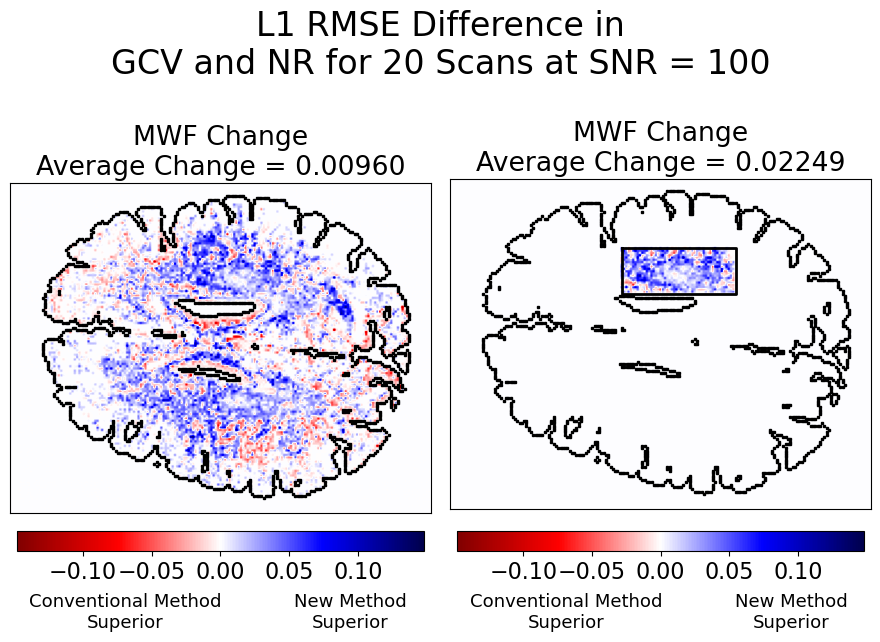

In [ ]:
### L1 MWF Change - all Noise Realizations

new_diff = (1/n_iter_input*np.sum(np.abs((GCV_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])), axis = 0))
old_diff = (1/n_iter_input*np.sum(np.abs((nonreg_estimates[:n_iter_input,:,:,0] - gs_nonreg_estimates[:,:,0])), axis = 0))

#Abbreviated as ACD
L1_MSE_Diff = old_diff - new_diff
L1_MSE_Range = np.max(np.abs(np.array([np.min(L1_MSE_Diff), np.max(L1_MSE_Diff)])))

# Zeroing all regions in the brain that aren't in the region of interest
L1_MSE_fullBrain = L1_MSE_Diff*masked_region[:,:,0]
L1_MSE_box = L1_MSE_Diff*boxed_region

# Making sure that only the region of interest is averaged
L1_MSE_fullBrain_values = L1_MSE_fullBrain[np.where(np.sum(exp_BIC_region, axis = 0) > 0)]
L1_MSE_box_values = L1_MSE_box[np.where(boxed_region)]



fig, ax = plt.subplots(1,2,figsize=(9,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'L1 RMSE Difference in\nGCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(L1_MSE_fullBrain, cmap = 'seismic_r', vmin=-L1_MSE_Range, vmax = L1_MSE_Range)
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title('MWF Change' + f'\nAverage Change = {np.mean(L1_MSE_fullBrain_values):0.5f}')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)


pNLLS = ax[1].imshow(L1_MSE_box, cmap = 'seismic_r', vmin=-L1_MSE_Range, vmax = L1_MSE_Range)
ax[1].plot([75,125,125,75,75],[30,30,50,50,30], linewidth = 2, color = 'k')
fig.colorbar(pNLLS,ax=ax[1], fraction=0.046, pad=0.05, location = 'bottom')
ax[1].set_title('MWF Change' + f'\nAverage Change = {np.mean(L1_MSE_box_values):0.5f}')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)


plt.rc('font', size  = 13)
fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.64, -0.05,"Conventional Method\nSuperior", ha='center')

plt.show()

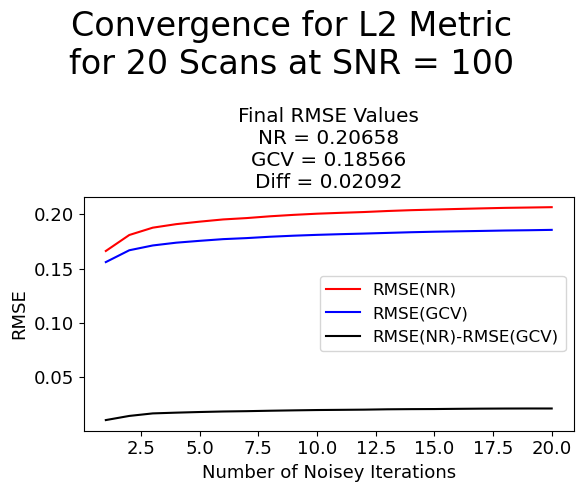

In [ ]:
### Metric Convergence

RMSE_diff_L2_hold = []
RMSE_old_L2_hold = []
RMSE_new_L2_hold = []

for iter in range(n_iter_input):

    n_NR = iter + 1

    new_diff = (1/n_NR*np.sum((GCV_estimates[:n_NR,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)
    old_diff = (1/n_NR*np.sum((nonreg_estimates[:n_NR,:,:,0] - gs_nonreg_estimates[:,:,0])**2, axis = 0))**(1/2)

    #Abbreviated as ACD
    absolute_comparative_diff = old_diff - new_diff

    BIC_region = (np.sum(exp_BIC_region, axis = 0) > 0)

    ACD = absolute_comparative_diff*BIC_region
    ND = new_diff*BIC_region
    OD = old_diff*BIC_region

    ACD_nonZ = ACD[BIC_region]
    ND_nonZ = ND[BIC_region]
    OD_nonZ = OD[BIC_region]

    RMSE_diff_L2_hold.append(np.mean(ACD_nonZ))
    RMSE_old_L2_hold.append(np.mean(OD_nonZ))
    RMSE_new_L2_hold.append(np.mean(ND_nonZ))

x_vals = np.arange(0,n_iter_input,1)+1

fig, ax = plt.subplots(1,1,figsize=(6,5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Convergence for L2 Metric\nfor {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 12)


ax.plot(x_vals, RMSE_old_L2_hold, color = 'r', label = 'RMSE(NR)')
ax.plot(x_vals, RMSE_new_L2_hold, color = 'b', label = 'RMSE(GCV)')
ax.plot(x_vals, RMSE_diff_L2_hold, color = 'k', label = 'RMSE(NR)-RMSE(GCV)')
ax.set_xlabel('Number of Noisey Iterations')
ax.set_ylabel('RMSE')
ax.set_title(f'Final RMSE Values\nNR = {RMSE_old_L2_hold[-1]:.5f}\nGCV = {RMSE_new_L2_hold[-1]:.5f}\nDiff = {RMSE_diff_L2_hold[-1]:.5f}')
ax.legend()


### Bad Pixel Analysis

In [ ]:
bp_vert = 60
bp_hori = 93

bp_GCV_estimates = GCV_estimates[:, bp_vert, bp_hori, :]
bp_GCV_lambdas = GCV_lambdas[:, bp_vert, bp_hori]
bp_nonreg_estimates = nonreg_estimates[:, bp_vert, bp_hori, :]
bp_gs_nonreg_estimates = gs_nonreg_estimates[bp_vert, bp_hori, :]

Text(0.2, -0.05, 'Conventional Method\nSuperior')

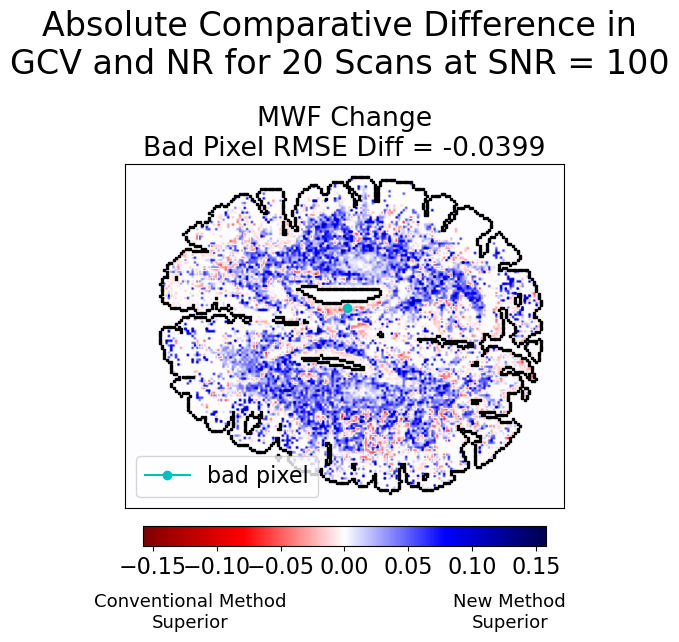

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Absolute Comparative Difference in\nGCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

ax.imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax.imshow(L2_MSE_fullBrain, cmap = 'seismic_r', vmin=-L2_MSE_Range, vmax = L2_MSE_Range)
ax.plot(bp_hori,bp_vert, marker = 'o', color = 'c', label = 'bad pixel')
cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
ax.set_title(f'MWF Change\nBad Pixel RMSE Diff = {L2_MSE_Diff[bp_vert, bp_hori]: 0.4f}')
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
ax.legend()

plt.rc('font', size  = 13)
fig.text(0.84, -0.05,"New Method\nSuperior", ha='center')
# fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
# fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.2, -0.05,"Conventional Method\nSuperior", ha='center')

In [ ]:
# print(f"Listing out all GCV lambdas associated with bad pixel:\n{bp_GCV_lambdas}")

print("True Estimate")

print(f"Standard Reference Param Est:\n{bp_gs_nonreg_estimates[0]:0.2f}, {bp_gs_nonreg_estimates[1]:0.2f}, {bp_gs_nonreg_estimates[2]:0.2f}, {bp_gs_nonreg_estimates[3]:0.2f}, {bp_gs_nonreg_estimates[4]:0.2f}")


print("\nSubsection of Nonregularized Estimates")
for i in range(5):

    print(f"Nonreg Param Est of iter {i+1}:\n{bp_nonreg_estimates[i,0]:0.2f}, {bp_nonreg_estimates[i,1]:0.2f}, {bp_nonreg_estimates[i,2]:0.2f}, {bp_nonreg_estimates[i,3]:0.2f}, {bp_nonreg_estimates[i,4]:0.2f}")


print("\nSubsection of GCV Regularized Estimates")
for i in range(5):

    print(f"GCV Param Est of iter {i+1}:\n{bp_GCV_estimates[i,0]:0.2f}, {bp_GCV_estimates[i,1]:0.2f}, {bp_GCV_estimates[i,2]:0.2f}, {bp_GCV_estimates[i,3]:0.2f}, {bp_GCV_estimates[i,4]:0.2f}")


True Estimate
Standard Reference Param Est:
0.69, 0.31, 57.21, 162.51, 0.15

Subsection of Nonregularized Estimates
Nonreg Param Est of iter 1:
0.73, 0.27, 56.84, 202.88, 0.13
Nonreg Param Est of iter 2:
0.00, 1.00, 0.00, 75.79, 0.19
Nonreg Param Est of iter 3:
0.00, 1.00, 0.00, 77.21, 0.18
Nonreg Param Est of iter 4:
0.73, 0.27, 57.74, 208.61, 0.13
Nonreg Param Est of iter 5:
0.00, 1.00, 0.00, 78.12, 0.18

Subsection of GCV Regularized Estimates
GCV Param Est of iter 1:
0.73, 0.27, 56.89, 201.84, 0.13
GCV Param Est of iter 2:
0.00, 1.00, 0.00, 75.79, 0.19
GCV Param Est of iter 3:
0.00, 1.00, 0.00, 77.21, 0.18
GCV Param Est of iter 4:
0.73, 0.27, 57.88, 205.81, 0.13
GCV Param Est of iter 5:
0.00, 1.00, 0.00, 78.12, 0.18


In [ ]:
### L1 Metric

new_diff = (1/n_iter_input*np.sum(np.abs((bp_GCV_estimates[:,0] - bp_gs_nonreg_estimates[0])), axis = 0))
old_diff = (1/n_iter_input*np.sum(np.abs((bp_nonreg_estimates[:,0] - bp_gs_nonreg_estimates[0])), axis = 0))

print("L1 Metric at Bad Pixel:")
print(f"L1 Diff of GCV and Standard Reference = {new_diff:.4f}")
print(f"L1 Diff of Conventional and Standard Reference = {old_diff:.4f}")
print(f"L1 Comparative Diff (conventional - new) = {old_diff - new_diff:.4f}")


### L2 Metric

new_diff = (1/n_iter_input*np.sum((bp_GCV_estimates[:,0] - bp_gs_nonreg_estimates[0])**2, axis = 0))**(1/2)
old_diff = (1/n_iter_input*np.sum((bp_nonreg_estimates[:,0] - bp_gs_nonreg_estimates[0])**2, axis = 0))**(1/2)

print("\n\nL2 Metric at Bad Pixel:")
print(f"L2 Diff of GCV and Standard Reference = {new_diff:.4f}")
print(f"L2 Diff of Conventional and Standard Reference = {old_diff:.4f}")
print(f"L2 Comparative Diff (conventional - new) = {old_diff - new_diff:.4f}")

L1 Metric at Bad Pixel:
L1 Diff of GCV and Standard Reference = 0.3984
L1 Diff of Conventional and Standard Reference = 0.3339
L1 Comparative Diff (conventional - new) = -0.0645


L2 Metric at Bad Pixel:
L2 Diff of GCV and Standard Reference = 0.4806
L2 Diff of Conventional and Standard Reference = 0.4407
L2 Comparative Diff (conventional - new) = -0.0399


In [ ]:
print("Nonreg Section for Bad Pixel")

array_oi = np.var(bp_nonreg_estimates, axis = 0)

print(f"Nonreg Param var:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

array_oi = np.mean(bp_nonreg_estimates, axis = 0) - bp_gs_nonreg_estimates

print(f"Nonreg Param Bias:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

print("\n\nGCV Section for Bad Pixel")

array_oi = np.var(bp_GCV_estimates, axis = 0)

print(f"GCV Param var:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

array_oi = np.mean(bp_GCV_estimates, axis = 0) - bp_gs_nonreg_estimates

print(f"GCV Param Bias:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

Nonreg Section for Bad Pixel
Nonreg Param var:
0.09, 0.09, 615.91, 3234.44, 0.00
Nonreg Param Bias:
-0.32, 0.32, -24.55, -35.24, 0.01


GCV Section for Bad Pixel
GCV Param var:
0.08, 0.08, 538.76, 3269.35, 0.00
GCV Param Bias:
-0.38, 0.38, -28.29, -43.36, 0.02


### Good Pixel Analysis

In [ ]:
gp_vert = 26
gp_hori = 85

gp_GCV_estimates = GCV_estimates[:, gp_vert, gp_hori, :]
gp_GCV_lambdas = GCV_lambdas[:, gp_vert, gp_hori]
gp_nonreg_estimates = nonreg_estimates[:, gp_vert, gp_hori, :]
gp_gs_nonreg_estimates = gs_nonreg_estimates[gp_vert, gp_hori, :]

Text(0.2, -0.05, 'Conventional Method\nSuperior')

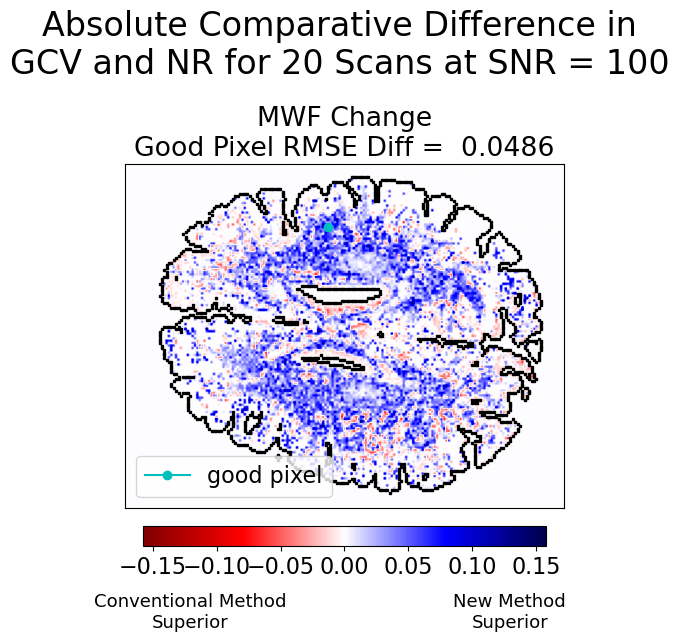

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(5,6),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Absolute Comparative Difference in\nGCV and NR for {n_iter_input} Scans at SNR = {SNR_goal}' )
plt.rc('font', size  = 16)

ax.imshow(1-brain_outline, cmap = 'gray', vmin=0, vmax = 1)
pNLLS = ax.imshow(L2_MSE_fullBrain, cmap = 'seismic_r', vmin=-L2_MSE_Range, vmax = L2_MSE_Range)
ax.plot(gp_hori, gp_vert, marker = 'o', color = 'c', label = 'good pixel')
cbar = fig.colorbar(pNLLS, ax=ax, fraction=0.046, pad=0.04, location = 'bottom')
ax.set_title(f'MWF Change\nGood Pixel RMSE Diff = {L2_MSE_Diff[gp_vert, gp_hori]: 0.4f}')
ax.tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax.plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
ax.legend()

plt.rc('font', size  = 13)
fig.text(0.84, -0.05,"New Method\nSuperior", ha='center')
# fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
# fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.2, -0.05,"Conventional Method\nSuperior", ha='center')

In [ ]:
# print(f"Listing out all GCV lambdas associated with bad pixel:\n{bp_GCV_lambdas}")

print("True Estimate")

print(f"Standard Reference Param Est of iter {i+1}:\n{gp_gs_nonreg_estimates[0]:0.2f}, {gp_gs_nonreg_estimates[1]:0.2f}, {gp_gs_nonreg_estimates[2]:0.2f}, {gp_gs_nonreg_estimates[3]:0.2f}, {gp_gs_nonreg_estimates[4]:0.2f}")


print("\nSubsection of Nonregularized Estimates")
for i in range(5):

    print(f"Nonreg Param Est of iter {i+1}:\n{gp_nonreg_estimates[i,0]:0.2f}, {gp_nonreg_estimates[i,1]:0.2f}, {gp_nonreg_estimates[i,2]:0.2f}, {gp_nonreg_estimates[i,3]:0.2f}, {gp_nonreg_estimates[i,4]:0.2f}")


print("\nSubsection of GCV Regularized Estimates")
for i in range(5):

    print(f"GCV Param Est of iter {i+1}:\n{gp_GCV_estimates[i,0]:0.2f}, {gp_GCV_estimates[i,1]:0.2f}, {gp_GCV_estimates[i,2]:0.2f}, {gp_GCV_estimates[i,3]:0.2f}, {gp_GCV_estimates[i,4]:0.2f}")


True Estimate
Standard Reference Param Est of iter 5:
0.24, 0.76, 30.92, 80.11, 0.02

Subsection of Nonregularized Estimates
Nonreg Param Est of iter 1:
0.28, 0.72, 30.47, 81.58, 0.02
Nonreg Param Est of iter 2:
0.16, 0.84, 22.32, 76.94, 0.01
Nonreg Param Est of iter 3:
0.19, 0.81, 26.17, 76.92, 0.02
Nonreg Param Est of iter 4:
0.31, 0.69, 35.36, 85.63, 0.01
Nonreg Param Est of iter 5:
0.24, 0.76, 31.19, 80.64, 0.02

Subsection of GCV Regularized Estimates
GCV Param Est of iter 1:
0.27, 0.73, 30.80, 80.16, 0.02
GCV Param Est of iter 2:
0.24, 0.76, 33.49, 81.09, 0.01
GCV Param Est of iter 3:
0.26, 0.74, 34.33, 80.33, 0.02
GCV Param Est of iter 4:
0.27, 0.73, 33.71, 82.25, 0.01
GCV Param Est of iter 5:
0.26, 0.74, 33.44, 81.07, 0.02


In [ ]:
### L1 Metric

new_diff = (1/n_iter_input*np.sum(np.abs((gp_GCV_estimates[:,0] - gp_gs_nonreg_estimates[0])), axis = 0))
old_diff = (1/n_iter_input*np.sum(np.abs((gp_nonreg_estimates[:,0] - gp_gs_nonreg_estimates[0])), axis = 0))

print("L1 Metric at Good Pixel:")
print(f"L1 Diff of GCV and Standard Reference = {new_diff:.4f}")
print(f"L1 Diff of Conventional and Standard Reference = {old_diff:.4f}")
print(f"L1 Comparative Diff (conventional - new) = {old_diff - new_diff:.4f}")


### L2 Metric

new_diff = (1/n_iter_input*np.sum((gp_GCV_estimates[:,0] - gp_gs_nonreg_estimates[0])**2, axis = 0))**(1/2)
old_diff = (1/n_iter_input*np.sum((gp_nonreg_estimates[:,0] - gp_gs_nonreg_estimates[0])**2, axis = 0))**(1/2)

print("\n\nL2 Metric at Good Pixel:")
print(f"L2 Diff of GCV and Standard Reference = {new_diff:.4f}")
print(f"L2 Diff of Conventional and Standard Reference = {old_diff:.4f}")
print(f"L2 Comparative Diff (conventional - new) = {old_diff - new_diff:.4f}")

L1 Metric at Good Pixel:
L1 Diff of GCV and Standard Reference = 0.0626
L1 Diff of Conventional and Standard Reference = 0.1161
L1 Comparative Diff (conventional - new) = 0.0535


L2 Metric at Good Pixel:
L2 Diff of GCV and Standard Reference = 0.1104
L2 Diff of Conventional and Standard Reference = 0.1590
L2 Comparative Diff (conventional - new) = 0.0486


In [ ]:
print("Nonreg Section for Good Pixel")

array_oi = np.var(gp_nonreg_estimates, axis = 0)

print(f"Nonreg Param var:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

array_oi = np.mean(gp_nonreg_estimates, axis = 0) - gp_gs_nonreg_estimates

print(f"Nonreg Param Bias:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

print("\n\nGCV Section for Good Pixel")

array_oi = np.var(gp_GCV_estimates, axis = 0)

print(f"GCV Param var:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

array_oi = np.mean(gp_GCV_estimates, axis = 0) - gp_gs_nonreg_estimates

print(f"GCV Param Bias:\n{array_oi[0]:0.2f}, {array_oi[1]:0.2f}, {array_oi[2]:0.2f}, {array_oi[3]:0.2f}, {array_oi[4]:0.2f}")

Nonreg Section for Good Pixel
Nonreg Param var:
0.02, 0.02, 162.72, 125.33, 0.00
Nonreg Param Bias:
0.03, -0.03, -1.68, 1.98, 0.00


GCV Section for Good Pixel
GCV Param var:
0.01, 0.01, 106.83, 78.02, 0.00
GCV Param Bias:
0.02, -0.02, -0.01, 0.93, 0.00


### Searching for Bad Pixel Reasons

Text(0.1, -0.05, 'Conventional Method\nSuperior')

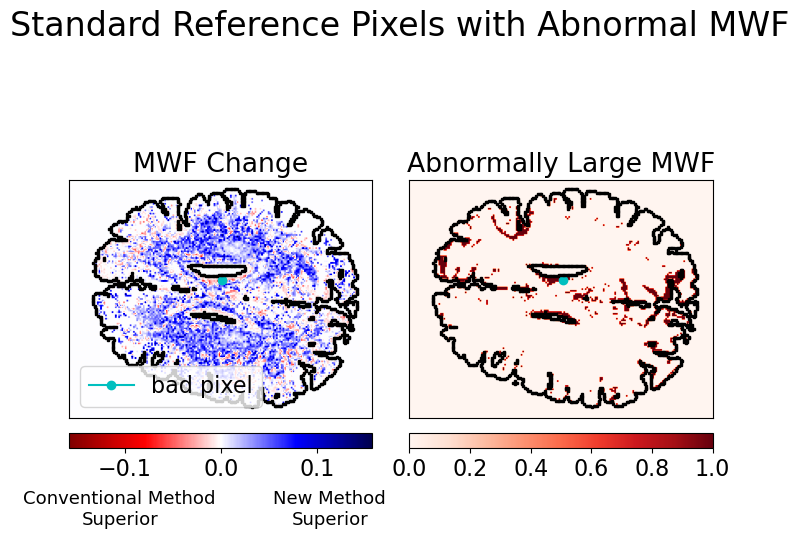

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(7,5),tight_layout=True)
plt.rc('font', size  = 20)
fig.suptitle(f'Standard Reference Pixels with Abnormal MWF' )
plt.rc('font', size  = 16)

pNLLS = ax[0].imshow(L2_MSE_fullBrain, cmap = 'seismic_r', vmin=-L2_MSE_Range, vmax = L2_MSE_Range)
ax[0].plot(bp_hori, bp_vert, marker = 'o', color = 'c', label = 'bad pixel')
cbar = fig.colorbar(pNLLS, ax=ax[0], fraction=0.046, pad=0.04, location = 'bottom')
ax[0].set_title(f'MWF Change')
ax[0].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[0].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
ax[0].legend()

pNLLS = ax[1].imshow(gs_nonreg_estimates[:,:,0]>gs_nonreg_estimates[:,:,1], cmap = 'Reds')
ax[1].plot(bp_hori, bp_vert, marker = 'o', color = 'c', label = 'bad pixel')
cbar = fig.colorbar(pNLLS, ax=ax[1], fraction=0.046, pad=0.04, location = 'bottom')
ax[1].set_title(f'Abnormally Large MWF')
ax[1].tick_params(left = False, bottom = False, labelbottom = False, labelleft = False)
ax[1].plot(outline_indices[1],outline_indices[0], color = 'k', marker = 's', ls = '', markersize = 1.5)
# ax[1].legend()

plt.rc('font', size  = 13)
fig.text(0.4, -0.05,"New Method\nSuperior", ha='center')
# fig.text(0.15, -0.05,"Conventional Method\nSuperior", ha='center')
# fig.text(0.89, -0.05,"New Method\nSuperior", ha='center')
fig.text(0.1, -0.05,"Conventional Method\nSuperior", ha='center')